# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (lrti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [18]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_antibacterial_brit_cat_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [19]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

In [20]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [21]:
#process 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [22]:
##add variable season
#convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] 
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

In [23]:
#add variable time period
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-01') & (data_lrti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [24]:
#scenario 1
#not hosped (nothing happened)
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0

In [25]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]

In [26]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [27]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30

#give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

In [28]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [29]:
#drop anybody with age less than 18 or 0!
data_lrti = data_lrti[~(data_lrti['age'] < 18)] 
data_lrti['age'][data_lrti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

In [30]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})

In [31]:
#drop rows with missing region
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
   data_lrti = data_lrti[data_lrti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_lrti.columns) and (data_lrti['smoking_status'].isnull().sum() > 0):
    data_lrti['smoking_status'] = data_lrti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

In [32]:
#missing values of bmi assign 5 and 0; categorise bmi
data_lrti['bmi_cat'] = 5

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 30:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 25) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 30):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 18.5) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 25):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 18.5:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

In [33]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])
#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)

In [34]:
##add a variable for category of antibiotic history 
#categorise antibiotic hisotry
data_lrti['antibacterial_brit_cat'] = pd.cut(data_lrti['antibacterial_brit'], right=False, bins=[0,1,2,5,10000], labels=['none0', 'low1', 'medium2_4', 'high5_more'])
data_lrti['antibacterial_brit_cat'].value_counts()

none0         91393
medium2_4     72672
low1          12041
high5_more     2013
Name: antibacterial_brit_cat, dtype: int64

### 2-4- translate values of categorical variables

In [35]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [36]:
#categorise CCI
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

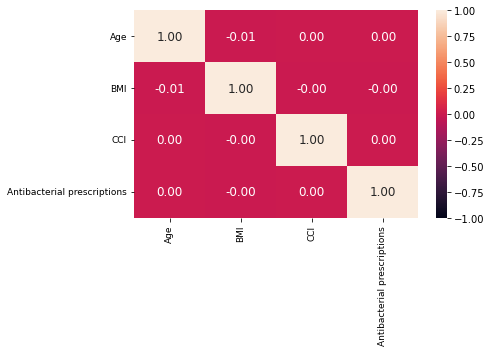

In [37]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [38]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'antibacterial_brit_cat', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                       'event_lrti_admitted', 'duration_lrti_admitted'
                       ]]

In [39]:
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]
#switch variable lrti_ab_date into a binary variable
data_lrti_incdt[['lrti_ab_date']] = data_lrti_incdt[['lrti_ab_date']].where(data_lrti_incdt[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_lrti_prevl[['lrti_ab_date']] = data_lrti_prevl[['lrti_ab_date']].where(data_lrti_prevl[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_lrti_incdt_males = data_lrti_incdt[data_lrti_incdt['sex'] == 'male']
data_lrti_incdt_females = data_lrti_incdt[data_lrti_incdt['sex'] == 'female']
data_lrti_prevl_males = data_lrti_prevl[data_lrti_prevl['sex'] == 'male']
data_lrti_prevl_females = data_lrti_prevl[data_lrti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_lrti_incdt_15_24 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '15_24']
data_lrti_incdt_25_34 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '25_34']
data_lrti_incdt_35_44 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '35_44']
data_lrti_incdt_45_54 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '45_54']
data_lrti_incdt_55_64 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '55_64']
data_lrti_incdt_65_74 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '65_74']
data_lrti_incdt_75_more = data_lrti_incdt[data_lrti_incdt['age_cat'] == '75_more']
data_lrti_prevl_15_24 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '15_24']
data_lrti_prevl_25_34 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '25_34']
data_lrti_prevl_35_44 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '35_44']
data_lrti_prevl_45_54 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '45_54']
data_lrti_prevl_55_64 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '55_64']
data_lrti_prevl_65_74 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '65_74']
data_lrti_prevl_75_more = data_lrti_prevl[data_lrti_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['date'] <= '2019-12']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['date'] >= '2020-03') & (data_lrti_incdt['date']<= '2021-03')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['date'] <= '2021-04']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['date'] <= '2019-12']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['date'] >= '2020-03') & (data_lrti_prevl['date']<= '2021-03')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['incdt_lrti_date'] == 0]

# with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_incdt = data_lrti_abs_incdt[data_lrti_abs_incdt['incdt_lrti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[data_lrti_no_abs_prevl['incdt_lrti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_prevl = data_lrti_abs_prevl[data_lrti_abs_prevl['incdt_lrti_date'] == 1]

In [40]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident lrti with no antibiotics

In [41]:
data_lrti_no_abs_incdt

,age_cat,sex,CCI_cat,flu_vaccine,bmi_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit,antibacterial_brit_cat,lrti_ab_date,ab_type_cat,incdt_lrti_date,date,period,event_lrti_admitted,duration_lrti_admitted
0,65_74,female,low,yes,obese,east_midlands,affluent,white,unknown,winter,0.0,none0,NaN,no,0,2022-01,post_2nd_lockdown,0.0,30.0
2,55_64,female,low,no,obese,west_midlands,unaffluent,white,smoker,winter,0.0,none0,NaN,no,0,2021-12,post_2nd_lockdown,0.0,30.0
10,75_more,male,low,no,unknown,london,very_affluent,white,never_smoked,summer,0.0,none0,NaN,no,0,2021-07,post_2nd_lockdown,0.0,30.0
11,35_44,male,high,no,obese,north_east,very_unaffluent,unknown,unknown,spring,0.0,none0,NaN,no,0,2020-03,during_pandemic,0.0,30.0
12,35_44,male,very_low,no,underweight,london,very_unaffluent,white,smoker,winter,0.0,none0,NaN,no,0,2020-01,during_pandemic,0.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360107,35_44,female,medium,no,obese,london,unaffluent,unknown,smoker,summer,2.0,medium2_4,NaN,no,0,2020-07,during_pandemic,0.0,30.0
360108,35_44,male,low,yes,healthy_weight,south_east,unaffluent,non-white,smoker,winter,0.0,none0,NaN,no,0,2022-12,post_2nd_lockdown,0.0,30.0
360114,35_44,female,low,yes,overweight,london,very_affluent,white,never_smoked,summer,0.0,none0,NaN,no,0,2021-06,post_2nd_lockdown,0.0,30.0
360115,75_more,male,high,no,obese,south_east,unaffluent,white,unknown,spring,3.0,medium2_4,NaN,no,0,2022-04,post_2nd_lockdown,0.0,30.0


<lifelines.CoxPHFitter: fitted with 108226 total observations, 107529 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 108226
number of events observed = 697
   partial log-likelihood = -8058.26
         time fit was run = 2023-06-26 10:26:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.11            -0.19             0.26                 0.83                 1.29
CCI_cat[T.medium]                0.12       1.13       0.12            -0.12             0.37                 0.89                 1.44
CCI_cat[T.high]                 -0.11       0.89       0.16            -0.42             0.20                 0.66                 1.22
CCI_cat[T.very_high]             0.09       1.10       0.13            -0.16             0.35                 0.85                 1.41
age_cat[T.25_34]                 0.04       1.04       0.14            -0.24             0.31                 0.79                 1.37
age_cat[T.35_44]                 0.03       1.03       0.14            -0.25             0.30                 0.78                 1.36
age_cat[T.45_54]                 0.07       1.07       0.14            -0.21             0.34                 0.81                 1.41
age_cat[T.55_64]                -0.16       0.85       0.15            -0.45             0.13                 0.64                 1.14
age_cat[T.65_74]                -0.05       0.95       0.14            -0.34             0.23                 0.71                 1.25
age_cat[T.75_more]               0.10       1.10       0.14            -0.18             0.37                 0.84                 1.44
antibacterial_brit               0.03       1.03       0.03            -0.02             0.08                 0.98                 1.09
bmi_cat[T.obese]                 0.10       1.10       0.14            -0.18             0.38                 0.83                 1.46
bmi_cat[T.overweight]            0.11       1.11       0.17            -0.23             0.45                 0.79                 1.57
bmi_cat[T.underweight]           0.33       1.38       0.23            -0.12             0.77                 0.89                 2.16
bmi_cat[T.unknown]              -0.11       0.90       0.16            -0.41             0.20                 0.66                 1.22
ethnicity[T.unknown]             0.17       1.18       0.12            -0.07             0.41                 0.93                 1.51
ethnicity[T.white]               0.00       1.00       0.11            -0.22             0.22                 0.80                 1.25
flu_vaccine[T.yes]               0.24       1.27       0.12             0.01             0.47                 1.01                 1.60
imd[T.medium]                    0.05       1.06       0.12            -0.18             0.29                 0.84                 1.33
imd[T.unaffluent]               -0.02       0.98       0.12            -0.26             0.21                 0.77                 1.24
imd[T.unknown]                  -0.23       0.80       0.20            -0.63             0.17                 0.53                 1.19
imd[T.very_affluent]            -0.15       0.86       0.12            -0.40             0.09                 0.67                 1.09
imd[T.very_unaffluent]          -0.11       0.90       0.12            -0.35             0.13                 0.70                 1.14
region[T.east_midlands]          0.11       1.11       0.17            -0.22             0.43                 0.81                 1.54
region[T.london]                -0.04       0.96       0.15      

12769


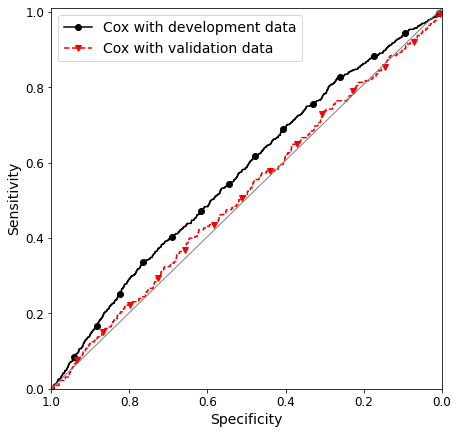

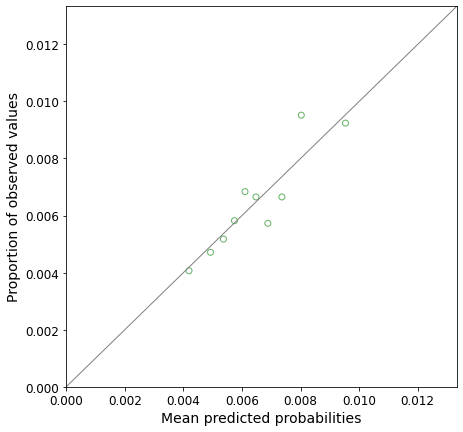

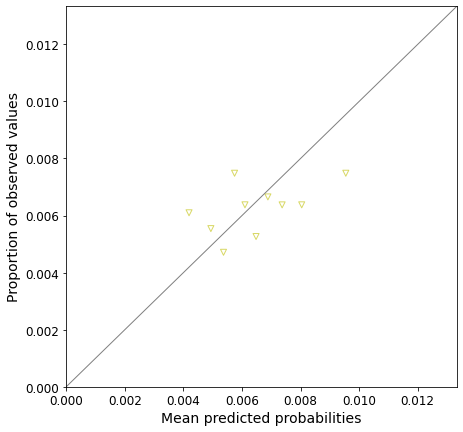

In [42]:
#data prep
data, data_lrti_no_abs_incdt_enc = cox_data_prep(data_lrti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

#build cox model 
cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = cox_model_build('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

#calculate and save betas and sum of betas 
cox_betas_sumbetas_calculate(cph_lrti_no_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_incdt.csv', data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt, 'sum_betas_cph_lrti_no_abs_incdt.csv')

#plot roc curve
cox_roc_curve(cph_lrti_no_abs_incdt, 'event_lrti_admitted', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_incdt.jpg')

#plot calibration plots with development and validation data
cox_calibration(cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, 'event_lrti_admitted', data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_incdt_train.jpg', 'calibration_cph_lrti_no_abs_incdt_test.jpg')

# calculate c-statistics
cox_output(cph_lrti_no_abs_incdt, 'lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

In [43]:
# #data prep
# data, data_lrti_no_abs_incdt_enc = cox_data_prep(data_lrti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary table
# make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_enc)

# #make summary table of hosped
# make_summary_table_hosped('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

# try:
#     #build cox model 
#     cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = cox_model_build('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)
# except:
#     print("error_1: the model did not converge or failed to finalise.")

# try:
#     #calculate and save betas and sum of betas 
#     cox_betas_sumbetas_calculate(cph_lrti_no_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_incdt.csv', data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt, 'sum_betas_cph_lrti_no_abs_incdt.csv')
# except:
#     print("\nerror_2: betas or sum of betas failed.")

# try:
#     #plot roc curve
#     cox_roc_curve(cph_lrti_no_abs_incdt, 'event_lrti_admitted', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_incdt.jpg')

#     #plot calibration plots with development and validation data
#     cox_calibration(cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, 'event_lrti_admitted', data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_incdt_train.jpg', 'calibration_cph_lrti_no_abs_incdt_test.jpg')
# except:
#     print("\nerror_3: roc curves or calibration curves failed.")

# try:
#     # calculate c-statistics
#     cox_output(cph_lrti_no_abs_incdt, 'lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
# except:
#     print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident lrti with antibiotics

In [44]:
data_lrti_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd',
       'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
       'antibacterial_brit_cat', 'lrti_ab_date', 'ab_type_cat',
       'incdt_lrti_date', 'date', 'period', 'event_lrti_admitted',
       'duration_lrti_admitted'],
      dtype='object')

In [45]:
data_lrti_abs_incdt

,age_cat,sex,CCI_cat,flu_vaccine,bmi_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit,antibacterial_brit_cat,lrti_ab_date,ab_type_cat,incdt_lrti_date,date,period,event_lrti_admitted,duration_lrti_admitted
1,55_64,female,medium,no,unknown,north_west,medium,white,unknown,spring,0.0,none0,2023-03-23,other,0,2022-04,post_2nd_lockdown,0.0,30.0
53,65_74,female,very_low,no,obese,west_midlands,affluent,non-white,ex_smoker,winter,3.0,medium2_4,2021-08-31,other,0,2021-12,post_2nd_lockdown,0.0,30.0
57,65_74,female,very_low,yes,unknown,london,very_affluent,white,unknown,spring,0.0,none0,2020-08-08,other,0,2021-04,post_2nd_lockdown,0.0,30.0
70,25_34,female,very_high,no,obese,north_east,very_unaffluent,white,never_smoked,spring,0.0,none0,2019-03-28,other,0,2021-03,during_pandemic,0.0,30.0
80,45_54,female,medium,no,obese,east_midlands,very_unaffluent,unknown,unknown,winter,0.0,none0,2019-09-26,other,0,2020-01,during_pandemic,0.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359992,65_74,female,very_high,no,obese,east_midlands,affluent,white,never_smoked,autumn,0.0,none0,2019-02-20,other,0,2021-10,post_2nd_lockdown,0.0,30.0
359995,35_44,female,low,no,overweight,east_midlands,unaffluent,unknown,never_smoked,spring,3.0,medium2_4,2021-10-02,other,0,2021-05,post_2nd_lockdown,0.0,30.0
360037,75_more,female,very_low,yes,obese,north_east,unknown,white,unknown,autumn,0.0,none0,2020-01-23,other,0,2020-11,during_pandemic,0.0,30.0
360091,45_54,female,high,no,obese,north_west,very_unaffluent,unknown,smoker,summer,0.0,none0,2021-07-30,other,0,2021-07,post_2nd_lockdown,0.0,30.0


<lifelines.CoxPHFitter: fitted with 11970 total observations, 11891 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 11970
number of events observed = 79
   partial log-likelihood = -724.55
         time fit was run = 2023-06-26 10:26:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.32            -0.62             0.65                 0.54                 1.92
CCI_cat[T.medium]                0.12       1.12       0.35            -0.58             0.81                 0.56                 2.24
CCI_cat[T.high]                 -0.56       0.57       0.52            -1.58             0.46                 0.21                 1.59
CCI_cat[T.very_high]            -0.28       0.76       0.40            -1.07             0.51                 0.34                 1.67
age_cat[T.25_34]                -0.24       0.78       0.47            -1.16             0.67                 0.31                 1.96
age_cat[T.35_44]                 0.24       1.27       0.40            -0.56             1.03                 0.57                 2.80
age_cat[T.45_54]                -0.05       0.96       0.44            -0.90             0.81                 0.41                 2.26
age_cat[T.55_64]                 0.21       1.23       0.41            -0.60             1.01                 0.55                 2.75
age_cat[T.65_74]                 0.27       1.31       0.40            -0.52             1.06                 0.59                 2.89
age_cat[T.75_more]              -0.13       0.88       0.45            -1.01             0.75                 0.36                 2.12
antibacterial_brit               0.03       1.03       0.08            -0.13             0.18                 0.88                 1.20
bmi_cat[T.obese]                 0.05       1.05       0.48            -0.89             0.99                 0.41                 2.68
bmi_cat[T.overweight]            0.84       2.32       0.51            -0.16             1.85                 0.85                 6.35
bmi_cat[T.underweight]          -0.06       0.94       0.84            -1.70             1.58                 0.18                 4.86
bmi_cat[T.unknown]               0.18       1.20       0.50            -0.80             1.16                 0.45                 3.19
ethnicity[T.unknown]            -0.05       0.95       0.36            -0.75             0.65                 0.47                 1.91
ethnicity[T.white]              -0.12       0.89       0.32            -0.74             0.50                 0.48                 1.65
flu_vaccine[T.yes]               0.43       1.54       0.31            -0.19             1.05                 0.83                 2.85
imd[T.medium]                    0.13       1.13       0.40            -0.66             0.91                 0.52                 2.49
imd[T.unaffluent]                0.09       1.09       0.40            -0.70             0.88                 0.50                 2.40
imd[T.unknown]                   0.85       2.34       0.48            -0.09             1.78                 0.92                 5.96
imd[T.very_affluent]             0.13       1.14       0.40            -0.65             0.92                 0.52                 2.51
imd[T.very_unaffluent]           0.60       1.83       0.36            -0.11             1.31                 0.90                 3.72
region[T.east_midlands]         -0.17       0.84       0.47            -1.09             0.74                 0.34                 2.09
region[T.london]                -0.34       0.71       0.40           

12772


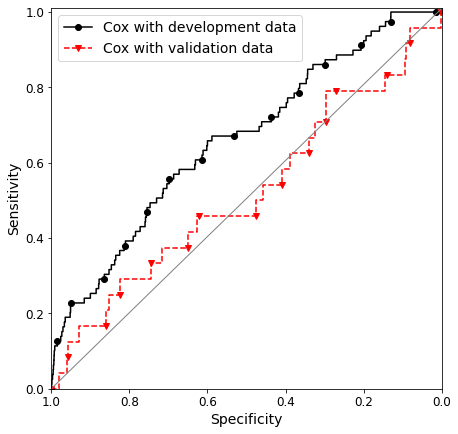

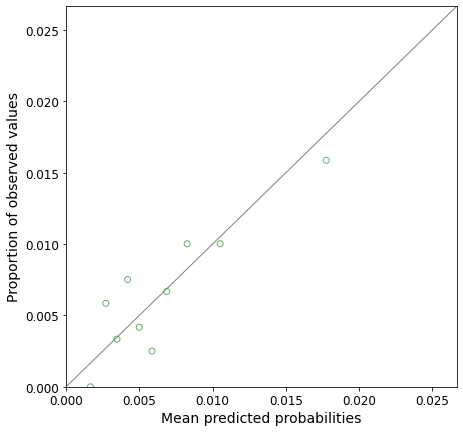

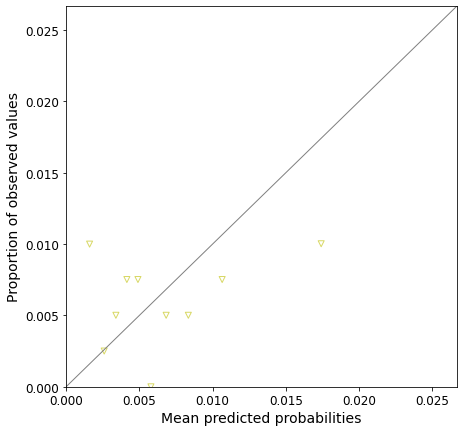

In [46]:
#data prep
data, data_lrti_abs_incdt_enc = cox_data_prep(data_lrti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_incdt', data_lrti_abs_incdt)

#build cox model 
cph_lrti_abs_incdt, data_lrti_abs_incdt_train, data_lrti_abs_incdt_test = cox_model_build('lrti', 'abs_incdt', data_lrti_abs_incdt)

#calculate and save betas and sum of betas 
cox_betas_sumbetas_calculate(cph_lrti_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_incdt.csv', data_lrti_abs_incdt_enc, data_lrti_abs_incdt, 'sum_betas_cph_lrti_abs_incdt.csv')

#plot roc curve
cox_roc_curve(cph_lrti_abs_incdt, 'event_lrti_admitted', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_incdt.jpg')

#plot calibration plots with development and validation data
cox_calibration(cph_lrti_abs_incdt, data_lrti_abs_incdt_train, 'event_lrti_admitted', data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_incdt_train.jpg', 'calibration_cph_lrti_abs_incdt_test.jpg')

#calculate c-statistics
cox_output(cph_lrti_abs_incdt, 'lrti', 'abs_incdt', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')

In [47]:
# #data prep
# data, data_lrti_abs_incdt_enc = cox_data_prep(data_lrti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

# #make summary table
# make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt_enc)

# #make summary table of hosped
# make_summary_table_hosped('lrti', 'abs_incdt', data_lrti_abs_incdt)

# try:
#     #build cox model 
#     cph_lrti_abs_incdt, data_lrti_abs_incdt_train, data_lrti_abs_incdt_test = cox_model_build('lrti', 'abs_incdt', data_lrti_abs_incdt)
# except:
#     print("error_1: the model did not converge or failed to finalise.")

# try:
#     #calculate and save betas and sum of betas 
#     cox_betas_sumbetas_calculate(cph_lrti_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_incdt.csv', data_lrti_abs_incdt_enc, data_lrti_abs_incdt, 'sum_betas_cph_lrti_abs_incdt.csv')
# except:
#     print("\nerror_2: betas or sum of betas failed.")

# try:
#     #plot roc curve
#     cox_roc_curve(cph_lrti_abs_incdt, 'event_lrti_admitted', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_incdt.jpg')

#     #plot calibration plots with development and validation data
#     cox_calibration(cph_lrti_abs_incdt, data_lrti_abs_incdt_train, 'event_lrti_admitted', data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_incdt_train.jpg', 'calibration_cph_lrti_abs_incdt_test.jpg')
# except:
#     print("\nerror_3: roc curves or calibration curves failed.")

# try:
#     # calculate c-statistics
#     cox_output(cph_lrti_abs_incdt, 'lrti', 'abs_incdt', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
# except:
#     print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 12038 total observations, 11958 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12038
number of events observed = 80
   partial log-likelihood = -733.57
         time fit was run = 2023-06-26 10:26:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.35            -0.39             0.98                 0.68                 2.66
CCI_cat[T.medium]                0.36       1.43       0.38            -0.38             1.10                 0.69                 3.00
CCI_cat[T.high]                 -0.20       0.82       0.51            -1.20             0.80                 0.30                 2.22
CCI_cat[T.very_high]            -0.01       0.99       0.43            -0.84             0.83                 0.43                 2.30
age_cat[T.25_34]                 0.40       1.48       0.46            -0.50             1.29                 0.61                 3.64
age_cat[T.35_44]                 0.51       1.66       0.45            -0.37             1.39                 0.69                 4.02
age_cat[T.45_54]                 0.20       1.22       0.48            -0.73             1.13                 0.48                 3.10
age_cat[T.55_64]                 0.26       1.29       0.48            -0.67             1.19                 0.51                 3.28
age_cat[T.65_74]                 0.46       1.58       0.45            -0.42             1.34                 0.66                 3.83
age_cat[T.75_more]               0.56       1.76       0.44            -0.31             1.44                 0.74                 4.20
antibacterial_brit               0.07       1.07       0.08            -0.08             0.22                 0.92                 1.25
bmi_cat[T.obese]                 0.10       1.10       0.44            -0.76             0.96                 0.47                 2.60
bmi_cat[T.overweight]            0.31       1.36       0.51            -0.69             1.31                 0.50                 3.70
bmi_cat[T.underweight]           1.16       3.20       0.56             0.07             2.26                 1.07                 9.57
bmi_cat[T.unknown]              -0.18       0.84       0.48            -1.13             0.77                 0.32                 2.16
ethnicity[T.unknown]            -0.25       0.78       0.35            -0.93             0.43                 0.40                 1.54
ethnicity[T.white]              -0.26       0.77       0.30            -0.85             0.32                 0.43                 1.38
flu_vaccine[T.yes]              -0.22       0.80       0.43            -1.06             0.61                 0.35                 1.84
imd[T.medium]                   -0.41       0.66       0.39            -1.18             0.36                 0.31                 1.43
imd[T.unaffluent]                0.07       1.07       0.34            -0.61             0.74                 0.54                 2.10
imd[T.unknown]                   0.39       1.48       0.48            -0.55             1.33                 0.58                 3.79
imd[T.very_affluent]            -0.14       0.87       0.37            -0.86             0.57                 0.42                 1.78
imd[T.very_unaffluent]          -0.10       0.90       0.36            -0.81             0.61                 0.45                 1.83
region[T.east_midlands]          0.16       1.17       0.49            -0.79             1.11                 0.45                 3.05
region[T.london]                -0.08       0.92       0.45           

12762


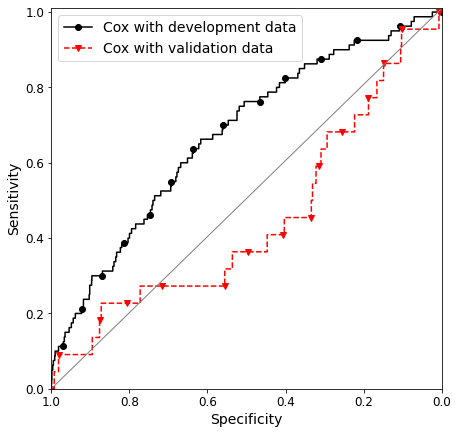

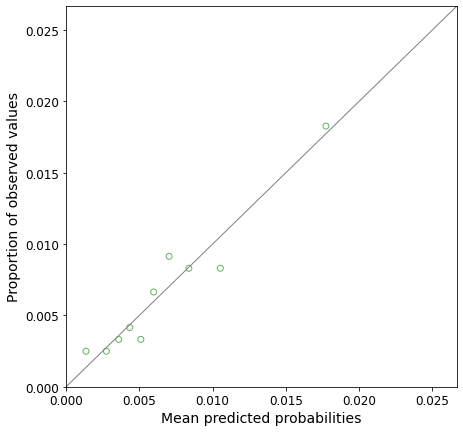

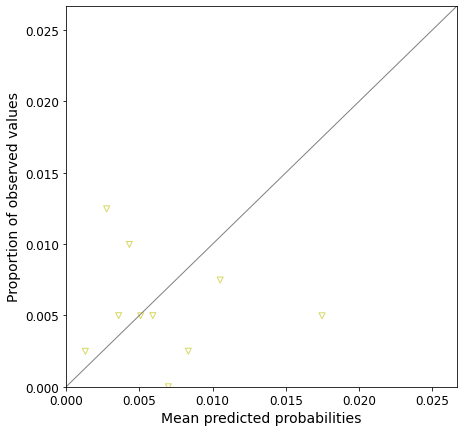

In [48]:
#data prep
data, data_lrti_no_abs_prevl_enc = cox_data_prep(data_lrti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)

try:
    #build cox model 
    cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test = cox_model_build('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_no_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_prevl.csv', data_lrti_no_abs_prevl_enc, data_lrti_no_abs_prevl, 'sum_betas_cph_lrti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_no_abs_prevl, 'event_lrti_admitted', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, 'event_lrti_admitted', data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_prevl_train.jpg', 'calibration_cph_lrti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_no_abs_prevl, 'lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 1353 total observations, 1343 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1353
number of events observed = 10
   partial log-likelihood = -41.73
         time fit was run = 2023-06-26 10:26:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.67       0.19       1.08            -3.78             0.45                 0.02                 1.57
CCI_cat[T.medium]               -3.36       0.03       1.69            -6.67            -0.06                 0.00                 0.94
CCI_cat[T.high]                -20.59       0.00    9233.16        -18117.24         18076.07                 0.00                  inf
CCI_cat[T.very_high]            -2.08       0.13       1.19            -4.41             0.25                 0.01                 1.28
age_cat[T.25_34]                 0.83       2.30   15158.17        -29708.62         29710.29                 0.00                  inf
age_cat[T.35_44]                 0.93       2.54   15352.45        -30089.32         30091.18                 0.00                  inf
age_cat[T.45_54]                22.20   4.38e+09    9962.63        -19504.19         19548.59                 0.00                  inf
age_cat[T.55_64]                22.44   5.54e+09    9962.63        -19503.95         19548.82                 0.00                  inf
age_cat[T.65_74]                21.72   2.70e+09    9962.63        -19504.67         19548.10                 0.00                  inf
age_cat[T.75_more]               1.12       3.06   15157.62        -29707.27         29709.51                 0.00                  inf
antibacterial_brit              -0.43       0.65       0.32            -1.07             0.20                 0.34                 1.22
bmi_cat[T.obese]                21.22   1.65e+09   10001.69        -19581.73         19624.17                 0.00                  inf
bmi_cat[T.overweight]            2.44      11.43   12408.46        -24317.69         24322.57                 0.00                  inf
bmi_cat[T.underweight]           2.37      10.71   22848.67        -44780.20         44784.95                 0.00                  inf
bmi_cat[T.unknown]              20.69   9.71e+08   10001.69        -19582.26         19623.64                 0.00                  inf
ethnicity[T.unknown]             0.06       1.06       1.39            -2.66             2.78                 0.07                16.07
ethnicity[T.white]               0.61       1.83       1.36            -2.06             3.27                 0.13                26.43
flu_vaccine[T.yes]             -18.71       0.00    8176.26        -16043.88         16006.46                 0.00                  inf
imd[T.medium]                    1.54       4.67       1.34            -1.09             4.17                 0.34                64.79
imd[T.unaffluent]               -0.56       0.57       1.66            -3.81             2.68                 0.02                14.62
imd[T.unknown]                   3.75      42.60       1.90             0.02             7.48                 1.02              1775.07
imd[T.very_affluent]             2.42      11.24       1.31            -0.16             4.99                 0.86               147.43
imd[T.very_unaffluent]         -17.69       0.00    5834.20        -11452.51         11417.12                 0.00                  inf
region[T.east_midlands]         -3.79       0.02       1.79            -7.29            -0.29                 0.00                 0.75
region[T.london]                -2.45       0.09       1.32            -5.

12982


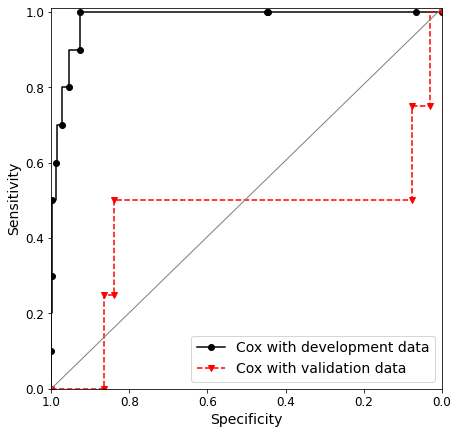

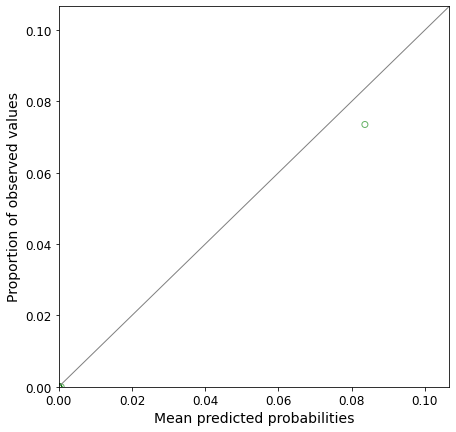

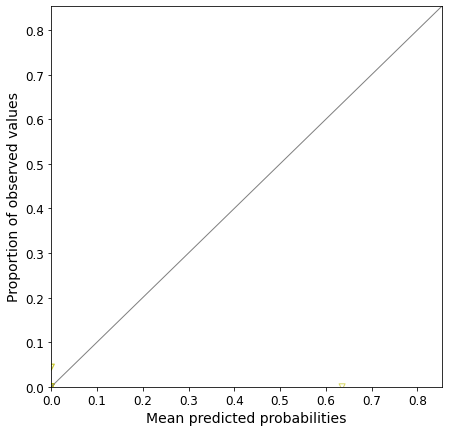

In [49]:
#data prep
data, data_lrti_abs_prevl_enc = cox_data_prep(data_lrti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_prevl', data_lrti_abs_prevl)

try:
    #build cox model 
    cph_lrti_abs_prevl, data_lrti_abs_prevl_train, data_lrti_abs_prevl_test = cox_model_build('lrti', 'abs_prevl', data_lrti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_prevl.csv', data_lrti_abs_prevl_enc, data_lrti_abs_prevl, 'sum_betas_cph_lrti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_abs_prevl, 'event_lrti_admitted', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_abs_prevl, data_lrti_abs_prevl_train, 'event_lrti_admitted', data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_prevl_train.jpg', 'calibration_cph_lrti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_abs_prevl, 'lrti', 'abs_prevl', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident lrti

In [50]:
#data prep
data, data_lrti_incdt_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'incdt', data_lrti_incdt_enc)
make_summary_table_hosped('lrti', 'incdt', data_lrti_incdt)

try:
    cph_lrti_incdt, data_lrti_incdt_train, data_lrti_incdt_test = cox_model_abs_build('lrti', 'incdt', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt, 'lrti', 'incdt', data_lrti_incdt_train, data_lrti_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120197 total observations, 119440 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 120197
number of events observed = 757
   partial log-likelihood = -8833.61
         time fit was run = 2023-06-26 10:26:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
CCI_cat[T.medium]               -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
CCI_cat[T.high]                 -0.18       0.84       0.15            -0.47             0.12                 0.62                 1.12
CCI_cat[T.very_high]             0.04       1.04       0.12            -0.20             0.27                 0.82                 1.32
age_cat[T.25_34]                -0.01       0.99       0.13            -0.26             0.25                 0.77                 1.29
age_cat[T.35_44]                -0.03       0.97       0.13            -0.29             0.23                 0.75                 1.25
age_cat[T.45_54]                -0.08       0.92       0.13            -0.35             0.18                 0.71                 1.20
age_cat[T.55_64]                -0.23       0.79       0.14            -0.50             0.04                 0.61                 1.04
age_cat[T.65_74]                -0.15       0.86       0.14            -0.42             0.11                 0.66                 1.12
age_cat[T.75_more]               0.00       1.00       0.13            -0.25             0.26                 0.78                 1.30
antibacterial_brit               0.02       1.02       0.03            -0.03             0.07                 0.97                 1.07
bmi_cat[T.obese]                 0.14       1.15       0.14            -0.14             0.42                 0.87                 1.52
bmi_cat[T.overweight]            0.21       1.24       0.17            -0.12             0.55                 0.89                 1.73
bmi_cat[T.underweight]           0.25       1.28       0.23            -0.21             0.70                 0.81                 2.02
bmi_cat[T.unknown]               0.05       1.05       0.15            -0.25             0.35                 0.78                 1.41
ethnicity[T.unknown]             0.12       1.13       0.12            -0.11             0.35                 0.89                 1.42
ethnicity[T.white]               0.04       1.04       0.11            -0.17             0.25                 0.84                 1.28
flu_vaccine[T.yes]               0.25       1.28       0.11             0.03             0.46                 1.03                 1.59
imd[T.medium]                    0.05       1.05       0.12            -0.18             0.28                 0.84                 1.32
imd[T.unaffluent]                0.03       1.03       0.12            -0.20             0.26                 0.82                 1.30
imd[T.unknown]                   0.04       1.04       0.18            -0.32             0.39                 0.73                 1.48
imd[T.very_affluent]            -0.08       0.92       0.12            -0.31             0.16                 0.73                 1.17
imd[T.very_unaffluent]           0.01       1.01       0.12            -0.22             0.24                 0.80                 1.27
lrti_ab_date                    -0.15       0.86       0.13            -0.41             0.10                 0.67                 1.10
region[T.east_midlands]          0.08       1.09       0.16      

13028


### 5-6- hospital admission related to prevalent lrti

In [51]:
#data prep
data, data_lrti_prevl_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'prevl', data_lrti_prevl_enc)
make_summary_table_hosped('lrti', 'prevl', data_lrti_prevl)

try:
    cph_lrti_prevl, data_lrti_prevl_train, data_lrti_prevl_test = cox_model_abs_build('lrti', 'prevl', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl, 'lrti', 'prevl', data_lrti_prevl_train, data_lrti_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13392 total observations, 13303 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13392
number of events observed = 89
   partial log-likelihood = -825.68
         time fit was run = 2023-06-26 10:26:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.37       0.31            -0.30             0.93                 0.74                 2.53
CCI_cat[T.medium]                0.11       1.12       0.35            -0.58             0.81                 0.56                 2.24
CCI_cat[T.high]                 -0.79       0.45       0.57            -1.90             0.32                 0.15                 1.38
CCI_cat[T.very_high]            -0.06       0.94       0.39            -0.82             0.70                 0.44                 2.00
age_cat[T.25_34]                 0.09       1.10       0.44            -0.77             0.95                 0.46                 2.58
age_cat[T.35_44]                 0.34       1.41       0.41            -0.47             1.15                 0.62                 3.17
age_cat[T.45_54]                 0.49       1.64       0.40            -0.30             1.29                 0.74                 3.62
age_cat[T.55_64]                 0.33       1.40       0.41            -0.48             1.15                 0.62                 3.14
age_cat[T.65_74]                 0.19       1.21       0.42            -0.63             1.02                 0.53                 2.77
age_cat[T.75_more]               0.13       1.14       0.44            -0.73             0.99                 0.48                 2.68
antibacterial_brit               0.02       1.02       0.07            -0.13             0.16                 0.88                 1.18
bmi_cat[T.obese]                 0.02       1.02       0.44            -0.85             0.88                 0.43                 2.40
bmi_cat[T.overweight]            0.72       2.06       0.48            -0.21             1.66                 0.81                 5.24
bmi_cat[T.underweight]           1.01       2.73       0.58            -0.13             2.14                 0.88                 8.51
bmi_cat[T.unknown]               0.13       1.14       0.46            -0.78             1.04                 0.46                 2.82
ethnicity[T.unknown]             0.14       1.15       0.34            -0.53             0.80                 0.59                 2.24
ethnicity[T.white]              -0.07       0.93       0.31            -0.68             0.54                 0.50                 1.71
flu_vaccine[T.yes]              -0.59       0.55       0.46            -1.49             0.31                 0.22                 1.37
imd[T.medium]                   -0.16       0.85       0.38            -0.90             0.59                 0.41                 1.80
imd[T.unaffluent]                0.27       1.30       0.34            -0.40             0.94                 0.67                 2.55
imd[T.unknown]                   0.29       1.34       0.52            -0.72             1.30                 0.48                 3.68
imd[T.very_affluent]             0.31       1.36       0.34            -0.36             0.98                 0.70                 2.67
imd[T.very_unaffluent]           0.10       1.10       0.36            -0.61             0.80                 0.54                 2.23
lrti_ab_date                     0.12       1.13       0.34            -0.54             0.78                 0.58                 2.18
region[T.east_midlands]          0.41       1.51       0.41           

13027


### 5-7- hospital admission related to incident lrti with prescribed antibiotics categories

In [52]:
#data prep
data, data_lrti_incdt_abs_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_abs, data_lrti_incdt_abs_train, data_lrti_incdt_abs_test = cox_model_ab_type_build('lrti', 'incdt_ab_type', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_abs, 'lrti', 'incdt_abs', data_lrti_incdt_abs_train, data_lrti_incdt_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120197 total observations, 119440 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 120197
number of events observed = 757
   partial log-likelihood = -8832.68
         time fit was run = 2023-06-26 10:26:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
CCI_cat[T.medium]               -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
CCI_cat[T.high]                 -0.18       0.84       0.15            -0.47             0.12                 0.62                 1.12
CCI_cat[T.very_high]             0.04       1.04       0.12            -0.20             0.27                 0.82                 1.32
ab_type_cat[T.Doxycycline]       0.52       1.68       0.73            -0.91             1.95                 0.40                 7.03
ab_type_cat[T.no]               -0.10       0.90       0.45            -0.98             0.78                 0.37                 2.17
ab_type_cat[T.other]            -0.30       0.74       0.47            -1.22             0.61                 0.30                 1.84
age_cat[T.25_34]                -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.29
age_cat[T.35_44]                -0.03       0.97       0.13            -0.29             0.23                 0.75                 1.25
age_cat[T.45_54]                -0.08       0.92       0.13            -0.35             0.18                 0.71                 1.20
age_cat[T.55_64]                -0.23       0.79       0.14            -0.50             0.04                 0.61                 1.04
age_cat[T.65_74]                -0.15       0.86       0.14            -0.42             0.11                 0.66                 1.12
age_cat[T.75_more]               0.00       1.00       0.13            -0.26             0.26                 0.77                 1.30
antibacterial_brit               0.02       1.02       0.03            -0.03             0.07                 0.97                 1.07
bmi_cat[T.obese]                 0.14       1.15       0.14            -0.14             0.42                 0.87                 1.52
bmi_cat[T.overweight]            0.21       1.24       0.17            -0.12             0.55                 0.89                 1.73
bmi_cat[T.underweight]           0.25       1.28       0.23            -0.21             0.70                 0.81                 2.02
bmi_cat[T.unknown]               0.05       1.05       0.15            -0.25             0.35                 0.78                 1.41
ethnicity[T.unknown]             0.12       1.13       0.12            -0.11             0.35                 0.89                 1.42
ethnicity[T.white]               0.04       1.04       0.11            -0.17             0.25                 0.84                 1.28
flu_vaccine[T.yes]               0.25       1.28       0.11             0.03             0.46                 1.03                 1.59
imd[T.medium]                    0.05       1.05       0.12            -0.18             0.28                 0.84                 1.32
imd[T.unaffluent]                0.03       1.03       0.12            -0.20             0.26                 0.82                 1.30
imd[T.unknown]                   0.03       1.03       0.18            -0.32             0.39                 0.73                 1.47
imd[T.very_affluent]            -0.08       0.92       0.12      

13593


### 5-8- hospital admission related to prevalent lrti with prescribed antibiotics categories

In [53]:
#data prep
data, data_lrti_prevl_abs_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_abs, data_lrti_prevl_abs_train, data_lrti_prevl_abs_test = cox_model_ab_type_build('lrti', 'prevl_ab_type', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_abs, 'lrti', 'prevl_abs', data_lrti_prevl_abs_train, data_lrti_prevl_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13392 total observations, 13303 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13392
number of events observed = 89
   partial log-likelihood = -824.71
         time fit was run = 2023-06-26 10:27:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.38       0.31            -0.29             0.93                 0.75                 2.54
CCI_cat[T.medium]                0.11       1.12       0.35            -0.58             0.80                 0.56                 2.24
CCI_cat[T.high]                 -0.78       0.46       0.57            -1.90             0.33                 0.15                 1.39
CCI_cat[T.very_high]            -0.06       0.94       0.39            -0.82             0.70                 0.44                 2.01
ab_type_cat[T.Doxycycline]      -0.13       0.87    4729.11         -9269.02          9268.75                 0.00                  inf
ab_type_cat[T.no]               14.87   2.88e+06    2125.59         -4151.20          4180.95                 0.00                  inf
ab_type_cat[T.other]            15.09   3.58e+06    2125.59         -4150.99          4181.17                 0.00                  inf
age_cat[T.25_34]                 0.10       1.10       0.44            -0.76             0.95                 0.47                 2.59
age_cat[T.35_44]                 0.34       1.40       0.41            -0.47             1.15                 0.62                 3.16
age_cat[T.45_54]                 0.50       1.64       0.40            -0.29             1.29                 0.75                 3.63
age_cat[T.55_64]                 0.34       1.40       0.41            -0.48             1.15                 0.62                 3.16
age_cat[T.65_74]                 0.19       1.21       0.42            -0.64             1.01                 0.53                 2.75
age_cat[T.75_more]               0.13       1.14       0.44            -0.73             0.99                 0.48                 2.68
antibacterial_brit               0.02       1.02       0.07            -0.13             0.16                 0.88                 1.18
bmi_cat[T.obese]                 0.01       1.01       0.44            -0.85             0.87                 0.43                 2.39
bmi_cat[T.overweight]            0.73       2.07       0.48            -0.21             1.66                 0.81                 5.24
bmi_cat[T.underweight]           1.01       2.74       0.58            -0.13             2.14                 0.88                 8.53
bmi_cat[T.unknown]               0.13       1.14       0.46            -0.78             1.04                 0.46                 2.83
ethnicity[T.unknown]             0.14       1.15       0.34            -0.53             0.81                 0.59                 2.24
ethnicity[T.white]              -0.07       0.93       0.31            -0.68             0.54                 0.51                 1.72
flu_vaccine[T.yes]              -0.59       0.55       0.46            -1.50             0.31                 0.22                 1.37
imd[T.medium]                   -0.16       0.86       0.38            -0.90             0.59                 0.41                 1.80
imd[T.unaffluent]                0.27       1.30       0.34            -0.41             0.94                 0.67                 2.55
imd[T.unknown]                   0.29       1.33       0.52            -0.73             1.30                 0.48                 3.68
imd[T.very_affluent]             0.31       1.37       0.34           

13626


### 5-9- stratified by sex
#### 5-9-1- incident males

In [54]:
#data prep
data, data_lrti_incdt_males_enc = cox_data_prep(data_lrti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_males, data_lrti_incdt_males_train, data_lrti_incdt_males_test = cox_model_strat_sex_build('lrti', 'incdt_males', data_lrti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_males, 'lrti', 'incdt_males', data_lrti_incdt_males_train, data_lrti_incdt_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 59070 total observations, 58671 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 59070
number of events observed = 399
   partial log-likelihood = -4360.52
         time fit was run = 2023-06-26 10:27:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.14            -0.43             0.13                 0.65                 1.14
CCI_cat[T.medium]               -0.10       0.91       0.16            -0.41             0.21                 0.66                 1.24
CCI_cat[T.high]                 -0.41       0.66       0.21            -0.83             0.01                 0.44                 1.01
CCI_cat[T.very_high]            -0.11       0.90       0.17            -0.43             0.22                 0.65                 1.25
age_cat[T.25_34]                -0.05       0.95       0.18            -0.41             0.31                 0.67                 1.37
age_cat[T.35_44]                -0.04       0.96       0.18            -0.39             0.32                 0.67                 1.37
age_cat[T.45_54]                -0.01       0.99       0.18            -0.36             0.34                 0.69                 1.41
age_cat[T.55_64]                -0.24       0.79       0.19            -0.62             0.13                 0.54                 1.14
age_cat[T.65_74]                -0.05       0.95       0.18            -0.40             0.31                 0.67                 1.36
age_cat[T.75_more]              -0.17       0.85       0.19            -0.54             0.20                 0.58                 1.22
antibacterial_brit               0.05       1.05       0.03            -0.02             0.12                 0.98                 1.12
bmi_cat[T.obese]                 0.52       1.67       0.23             0.07             0.96                 1.07                 2.62
bmi_cat[T.overweight]            0.44       1.55       0.27            -0.09             0.96                 0.92                 2.61
bmi_cat[T.underweight]           0.57       1.77       0.35            -0.10             1.25                 0.90                 3.49
bmi_cat[T.unknown]               0.50       1.65       0.24             0.03             0.97                 1.03                 2.63
ethnicity[T.unknown]             0.09       1.10       0.16            -0.23             0.42                 0.80                 1.52
ethnicity[T.white]               0.03       1.03       0.15            -0.26             0.32                 0.77                 1.38
flu_vaccine[T.yes]               0.26       1.30       0.15            -0.04             0.56                 0.96                 1.75
imd[T.medium]                   -0.11       0.90       0.16            -0.41             0.20                 0.66                 1.22
imd[T.unaffluent]               -0.07       0.93       0.16            -0.38             0.23                 0.68                 1.26
imd[T.unknown]                  -0.24       0.79       0.26            -0.74             0.27                 0.47                 1.31
imd[T.very_affluent]            -0.39       0.68       0.17            -0.72            -0.06                 0.49                 0.94
imd[T.very_unaffluent]          -0.11       0.90       0.16            -0.42             0.20                 0.66                 1.22
lrti_ab_date                     0.25       1.28       0.15            -0.05             0.54                 0.95                 1.72
region[T.east_midlands]          0.01       1.01       0.21         

12782


#### 5-9-2- incident females

In [55]:
#data prep
data, data_lrti_incdt_females_enc = cox_data_prep(data_lrti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_females, data_lrti_incdt_females_train, data_lrti_incdt_females_test = cox_model_strat_sex_build('lrti', 'incdt_females', data_lrti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_females, 'lrti', 'incdt_females', data_lrti_incdt_females_train, data_lrti_incdt_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61127 total observations, 60737 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 61127
number of events observed = 390
   partial log-likelihood = -4282.41
         time fit was run = 2023-06-26 10:27:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.16            -0.25             0.36                 0.78                 1.44
CCI_cat[T.medium]                0.15       1.16       0.17            -0.18             0.48                 0.84                 1.61
CCI_cat[T.high]                  0.10       1.11       0.20            -0.30             0.50                 0.74                 1.65
CCI_cat[T.very_high]             0.14       1.15       0.18            -0.21             0.49                 0.81                 1.63
age_cat[T.25_34]                 0.15       1.17       0.19            -0.22             0.52                 0.81                 1.69
age_cat[T.35_44]                -0.05       0.95       0.20            -0.44             0.34                 0.65                 1.41
age_cat[T.45_54]                 0.03       1.03       0.20            -0.36             0.41                 0.70                 1.51
age_cat[T.55_64]                -0.07       0.94       0.20            -0.46             0.32                 0.63                 1.38
age_cat[T.65_74]                 0.15       1.16       0.19            -0.22             0.52                 0.80                 1.68
age_cat[T.75_more]               0.22       1.24       0.19            -0.15             0.58                 0.86                 1.79
antibacterial_brit               0.02       1.02       0.04            -0.05             0.09                 0.95                 1.09
bmi_cat[T.obese]                -0.26       0.77       0.17            -0.60             0.07                 0.55                 1.08
bmi_cat[T.overweight]           -0.18       0.84       0.21            -0.60             0.25                 0.55                 1.28
bmi_cat[T.underweight]          -0.02       0.98       0.30            -0.59             0.56                 0.55                 1.75
bmi_cat[T.unknown]              -0.34       0.71       0.19            -0.71             0.03                 0.49                 1.03
ethnicity[T.unknown]             0.22       1.24       0.17            -0.11             0.55                 0.89                 1.73
ethnicity[T.white]               0.10       1.10       0.15            -0.20             0.40                 0.82                 1.49
flu_vaccine[T.yes]               0.15       1.17       0.16            -0.16             0.47                 0.85                 1.60
imd[T.medium]                    0.29       1.34       0.17            -0.04             0.62                 0.96                 1.86
imd[T.unaffluent]                0.23       1.25       0.17            -0.11             0.56                 0.89                 1.75
imd[T.unknown]                   0.23       1.26       0.26            -0.28             0.73                 0.76                 2.08
imd[T.very_affluent]             0.32       1.38       0.17            -0.01             0.65                 0.99                 1.92
imd[T.very_unaffluent]           0.09       1.09       0.18            -0.26             0.43                 0.77                 1.54
lrti_ab_date                    -0.13       0.88       0.18            -0.49             0.22                 0.62                 1.24
region[T.east_midlands]          0.00       1.00       0.24         

12760


#### 5-9-3- prevalent males

In [56]:
#data prep
data, data_lrti_prevl_males_enc = cox_data_prep(data_lrti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_males, data_lrti_prevl_males_train, data_lrti_prevl_males_test = cox_model_strat_sex_build('lrti', 'prevl_males', data_lrti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_lrti_prevl_males, 'lrti', 'prevl_males', data_lrti_prevl_males_train, data_lrti_prevl_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6620 total observations, 6583 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6620
number of events observed = 37
   partial log-likelihood = -308.16
         time fit was run = 2023-06-26 10:27:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.76       2.14       0.56            -0.33             1.85                 0.72                 6.38
CCI_cat[T.medium]                0.67       1.96       0.60            -0.51             1.85                 0.60                 6.39
CCI_cat[T.high]                 -0.22       0.81       0.87            -1.92             1.48                 0.15                 4.41
CCI_cat[T.very_high]             0.32       1.37       0.67            -1.00             1.64                 0.37                 5.14
age_cat[T.25_34]                -0.05       0.95       0.71            -1.44             1.33                 0.24                 3.80
age_cat[T.35_44]                 0.46       1.58       0.65            -0.81             1.73                 0.44                 5.64
age_cat[T.45_54]                 0.49       1.64       0.63            -0.74             1.73                 0.48                 5.63
age_cat[T.55_64]                 0.44       1.55       0.65            -0.83             1.71                 0.43                 5.50
age_cat[T.65_74]                -0.03       0.97       0.71            -1.42             1.35                 0.24                 3.88
age_cat[T.75_more]               0.41       1.51       0.65            -0.86             1.68                 0.42                 5.36
antibacterial_brit               0.17       1.18       0.11            -0.05             0.38                 0.95                 1.47
bmi_cat[T.obese]                 0.18       1.19       0.62            -1.04             1.39                 0.35                 4.03
bmi_cat[T.overweight]            0.03       1.03       0.77            -1.47             1.54                 0.23                 4.65
bmi_cat[T.underweight]          -0.18       0.83       1.16            -2.45             2.09                 0.09                 8.07
bmi_cat[T.unknown]              -0.07       0.93       0.68            -1.41             1.26                 0.25                 3.53
ethnicity[T.unknown]            -0.17       0.85       0.77            -1.67             1.33                 0.19                 3.80
ethnicity[T.white]               0.99       2.70       0.61            -0.20             2.18                 0.82                 8.89
flu_vaccine[T.yes]              -0.54       0.58       0.73            -1.97             0.89                 0.14                 2.42
imd[T.medium]                    0.12       1.13       0.49            -0.84             1.08                 0.43                 2.93
imd[T.unaffluent]                0.16       1.18       0.49            -0.80             1.12                 0.45                 3.07
imd[T.unknown]                  -0.73       0.48       1.06            -2.81             1.36                 0.06                 3.88
imd[T.very_affluent]            -0.01       0.99       0.50            -0.99             0.98                 0.37                 2.66
imd[T.very_unaffluent]          -1.46       0.23       0.79            -3.01             0.09                 0.05                 1.10
lrti_ab_date                     0.21       1.23       0.53            -0.83             1.25                 0.44                 3.50
region[T.east_midlands]          0.23       1.26       0.67            -1

12759


#### 5-9-4- prevalent females

In [57]:
try:
    #data prep
    data, data_lrti_prevl_females_enc = cox_data_prep(data_lrti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

    #cox model
    cph_lrti_prevl_females, data_lrti_prevl_females_train, data_lrti_prevl_females_test = cox_model_strat_sex_build('lrti', 'prevl_females', data_lrti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_females, 'lrti', 'prevl_females', data_lrti_prevl_females_train, data_lrti_prevl_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6771 total observations, 6722 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6771
number of events observed = 49
   partial log-likelihood = -418.32
         time fit was run = 2023-06-26 10:27:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.10       0.42            -0.74             0.92                 0.48                 2.52
CCI_cat[T.medium]                0.13       1.14       0.46            -0.77             1.03                 0.46                 2.80
CCI_cat[T.high]                 -0.56       0.57       0.68            -1.89             0.77                 0.15                 2.16
CCI_cat[T.very_high]            -0.12       0.88       0.52            -1.14             0.89                 0.32                 2.45
age_cat[T.25_34]                 0.46       1.58       0.57            -0.66             1.58                 0.51                 4.86
age_cat[T.35_44]                 0.36       1.43       0.59            -0.79             1.51                 0.45                 4.52
age_cat[T.45_54]                 0.27       1.31       0.61            -0.92             1.46                 0.40                 4.30
age_cat[T.55_64]                 0.78       2.18       0.55            -0.30             1.85                 0.74                 6.39
age_cat[T.65_74]                 0.46       1.59       0.57            -0.66             1.58                 0.52                 4.87
age_cat[T.75_more]               0.08       1.08       0.63            -1.17             1.32                 0.31                 3.74
antibacterial_brit              -0.01       0.99       0.10            -0.21             0.19                 0.81                 1.21
bmi_cat[T.obese]                 0.29       1.33       0.61            -0.91             1.49                 0.40                 4.44
bmi_cat[T.overweight]            0.70       2.01       0.68            -0.64             2.03                 0.53                 7.60
bmi_cat[T.underweight]           1.08       2.96       0.82            -0.53             2.69                 0.59                14.80
bmi_cat[T.unknown]               0.13       1.14       0.66            -1.16             1.42                 0.31                 4.15
ethnicity[T.unknown]             0.26       1.30       0.43            -0.58             1.11                 0.56                 3.02
ethnicity[T.white]              -0.27       0.76       0.41            -1.08             0.53                 0.34                 1.70
flu_vaccine[T.yes]              -0.91       0.40       0.72            -2.32             0.51                 0.10                 1.67
imd[T.medium]                   -0.19       0.83       0.46            -1.09             0.72                 0.34                 2.04
imd[T.unaffluent]               -0.42       0.66       0.49            -1.39             0.55                 0.25                 1.73
imd[T.unknown]                   0.13       1.14       0.66            -1.16             1.43                 0.31                 4.18
imd[T.very_affluent]            -0.14       0.87       0.46            -1.05             0.76                 0.35                 2.14
imd[T.very_unaffluent]           0.07       1.08       0.44            -0.79             0.93                 0.46                 2.54
lrti_ab_date                    -0.04       0.96       0.47            -0.97             0.88                 0.38                 2.42
region[T.east_midlands]         -0.24       0.79       0.59            -1

12805


### 5-10- stratified by age category
#### 5-10-1- incident

In [58]:
#data prep
data, data_lrti_incdt_15_24_enc = cox_data_prep(data_lrti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_15_24, data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test = cox_model_strat_age_build('lrti', 'incdt_15_24', data_lrti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_15_24, 'lrti', 'incdt_15_24', data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17148 total observations, 17038 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17148
number of events observed = 110
   partial log-likelihood = -1048.75
         time fit was run = 2023-06-26 10:27:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.33       0.72       0.28            -0.88             0.23                 0.41                 1.25
CCI_cat[T.medium]                0.20       1.22       0.29            -0.36             0.76                 0.70                 2.14
CCI_cat[T.high]                 -0.05       0.95       0.36            -0.76             0.66                 0.47                 1.94
CCI_cat[T.very_high]            -0.29       0.74       0.33            -0.95             0.36                 0.39                 1.43
antibacterial_brit              -0.02       0.98       0.07            -0.15             0.11                 0.86                 1.12
bmi_cat[T.obese]                 0.57       1.77       0.47            -0.34             1.49                 0.71                 4.43
bmi_cat[T.overweight]            0.47       1.60       0.55            -0.60             1.55                 0.55                 4.70
bmi_cat[T.underweight]           1.22       3.37       0.61             0.03             2.40                 1.03                11.07
bmi_cat[T.unknown]               0.78       2.19       0.48            -0.16             1.73                 0.85                 5.62
ethnicity[T.unknown]            -0.03       0.97       0.27            -0.56             0.50                 0.57                 1.65
ethnicity[T.white]              -0.53       0.59       0.25            -1.03            -0.03                 0.36                 0.97
flu_vaccine[T.yes]               0.17       1.19       0.30            -0.41             0.75                 0.67                 2.12
imd[T.medium]                    0.06       1.07       0.29            -0.50             0.63                 0.61                 1.87
imd[T.unaffluent]               -0.24       0.79       0.32            -0.86             0.38                 0.42                 1.46
imd[T.unknown]                   0.28       1.32       0.41            -0.53             1.08                 0.59                 2.96
imd[T.very_affluent]            -0.10       0.90       0.30            -0.69             0.48                 0.50                 1.62
imd[T.very_unaffluent]          -0.60       0.55       0.35            -1.28             0.08                 0.28                 1.08
lrti_ab_date                    -0.06       0.94       0.32            -0.68             0.56                 0.51                 1.76
region[T.east_midlands]         -0.09       0.91       0.38            -0.84             0.65                 0.43                 1.92
region[T.london]                -0.35       0.71       0.34            -1.01             0.31                 0.37                 1.36
region[T.north_east]            -0.27       0.76       0.38            -1.01             0.47                 0.36                 1.61
region[T.north_west]            -1.64       0.19       0.63            -2.88            -0.40                 0.06                 0.67
region[T.south_east]            -0.17       0.84       0.38            -0.92             0.57                 0.40                 1.77
region[T.south_west]            -0.41       0.66       0.41            -1.21             0.39                 0.30                 1.48
region[T.west_midlands]         -0.47       0.62       0.41         

11409


In [59]:
#data prep
data, data_lrti_incdt_25_34_enc = cox_data_prep(data_lrti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_25_34, data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test = cox_model_strat_age_build('lrti', 'incdt_25_34', data_lrti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_25_34, 'lrti', 'incdt_25_34', data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16957 total observations, 16861 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 16957
number of events observed = 96
   partial log-likelihood = -917.23
         time fit was run = 2023-06-26 10:27:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.28            -0.64             0.47                 0.53                 1.61
CCI_cat[T.medium]               -0.33       0.72       0.33            -0.99             0.32                 0.37                 1.38
CCI_cat[T.high]                 -0.67       0.51       0.47            -1.59             0.25                 0.20                 1.29
CCI_cat[T.very_high]            -0.15       0.86       0.33            -0.81             0.51                 0.45                 1.66
antibacterial_brit               0.04       1.04       0.07            -0.10             0.17                 0.90                 1.19
bmi_cat[T.obese]                 0.23       1.26       0.40            -0.55             1.02                 0.57                 2.78
bmi_cat[T.overweight]            0.03       1.03       0.51            -0.96             1.02                 0.38                 2.78
bmi_cat[T.underweight]           0.40       1.49       0.63            -0.83             1.63                 0.43                 5.11
bmi_cat[T.unknown]               0.06       1.06       0.43            -0.80             0.91                 0.45                 2.48
ethnicity[T.unknown]            -0.14       0.87       0.31            -0.74             0.46                 0.48                 1.58
ethnicity[T.white]              -0.37       0.69       0.27            -0.91             0.17                 0.40                 1.18
flu_vaccine[T.yes]               0.76       2.13       0.26             0.24             1.27                 1.28                 3.57
imd[T.medium]                    0.09       1.09       0.31            -0.52             0.69                 0.59                 2.00
imd[T.unaffluent]                0.06       1.06       0.31            -0.55             0.68                 0.58                 1.97
imd[T.unknown]                  -0.97       0.38       0.74            -2.43             0.48                 0.09                 1.62
imd[T.very_affluent]            -0.56       0.57       0.38            -1.30             0.18                 0.27                 1.19
imd[T.very_unaffluent]           0.00       1.00       0.32            -0.62             0.62                 0.54                 1.87
lrti_ab_date                    -0.03       0.97       0.35            -0.71             0.66                 0.49                 1.94
region[T.east_midlands]         -0.19       0.83       0.48            -1.12             0.75                 0.33                 2.11
region[T.london]                 0.12       1.13       0.38            -0.62             0.87                 0.54                 2.38
region[T.north_east]            -0.23       0.80       0.47            -1.16             0.70                 0.31                 2.02
region[T.north_west]            -0.49       0.61       0.52            -1.50             0.52                 0.22                 1.69
region[T.south_east]             0.11       1.12       0.44            -0.75             0.97                 0.47                 2.64
region[T.south_west]             0.02       1.02       0.45            -0.86             0.90                 0.42                 2.46
region[T.west_midlands]         -0.07       0.93       0.46           

11405


In [60]:
#data prep
data, data_lrti_incdt_35_44_enc = cox_data_prep(data_lrti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_35_44, data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test = cox_model_strat_age_build('lrti', 'incdt_35_44', data_lrti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_35_44, 'lrti', 'incdt_35_44', data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17128 total observations, 17009 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17128
number of events observed = 119
   partial log-likelihood = -1140.92
         time fit was run = 2023-06-26 10:27:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.26            -0.72             0.31                 0.49                 1.37
CCI_cat[T.medium]               -0.08       0.92       0.29            -0.64             0.48                 0.53                 1.62
CCI_cat[T.high]                 -0.35       0.70       0.38            -1.09             0.39                 0.33                 1.48
CCI_cat[T.very_high]            -0.15       0.86       0.31            -0.75             0.45                 0.47                 1.57
antibacterial_brit              -0.05       0.95       0.07            -0.18             0.08                 0.84                 1.09
bmi_cat[T.obese]                 0.05       1.05       0.36            -0.65             0.75                 0.52                 2.11
bmi_cat[T.overweight]            0.15       1.16       0.42            -0.68             0.97                 0.51                 2.65
bmi_cat[T.underweight]         -15.76       0.00    1430.17         -2818.84          2787.32                 0.00                  inf
bmi_cat[T.unknown]               0.10       1.11       0.38            -0.64             0.85                 0.53                 2.33
ethnicity[T.unknown]             0.00       1.00       0.29            -0.58             0.58                 0.56                 1.78
ethnicity[T.white]              -0.02       0.98       0.26            -0.53             0.48                 0.59                 1.62
flu_vaccine[T.yes]              -0.30       0.74       0.35            -0.98             0.38                 0.37                 1.46
imd[T.medium]                    0.20       1.23       0.27            -0.33             0.74                 0.72                 2.09
imd[T.unaffluent]               -0.11       0.90       0.30            -0.69             0.47                 0.50                 1.61
imd[T.unknown]                  -0.45       0.64       0.54            -1.51             0.61                 0.22                 1.85
imd[T.very_affluent]            -0.30       0.74       0.32            -0.92             0.32                 0.40                 1.38
imd[T.very_unaffluent]          -0.14       0.87       0.30            -0.73             0.45                 0.48                 1.57
lrti_ab_date                    -0.02       0.98       0.30            -0.62             0.58                 0.54                 1.78
region[T.east_midlands]         -0.30       0.74       0.43            -1.15             0.55                 0.32                 1.74
region[T.london]                -0.34       0.71       0.36            -1.04             0.37                 0.35                 1.45
region[T.north_east]             0.44       1.56       0.36            -0.26             1.14                 0.77                 3.13
region[T.north_west]            -0.22       0.80       0.42            -1.05             0.60                 0.35                 1.83
region[T.south_east]            -0.45       0.64       0.45            -1.33             0.43                 0.26                 1.54
region[T.south_west]             0.12       1.13       0.39            -0.63             0.88                 0.53                 2.41
region[T.west_midlands]          0.38       1.46       0.36         

11410


In [61]:
#data prep
data, data_lrti_incdt_45_54_enc = cox_data_prep(data_lrti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_45_54, data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test = cox_model_strat_age_build('lrti', 'incdt_45_54', data_lrti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_45_54, 'lrti', 'incdt_45_54', data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17091 total observations, 16970 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17091
number of events observed = 121
   partial log-likelihood = -1155.80
         time fit was run = 2023-06-26 10:27:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.43       0.31            -0.25             0.96                 0.78                 2.61
CCI_cat[T.medium]                0.53       1.70       0.33            -0.11             1.17                 0.90                 3.23
CCI_cat[T.high]                  0.73       2.08       0.36             0.02             1.44                 1.02                 4.22
CCI_cat[T.very_high]             0.26       1.30       0.36            -0.44             0.96                 0.65                 2.62
antibacterial_brit               0.08       1.08       0.06            -0.04             0.20                 0.96                 1.22
bmi_cat[T.obese]                -0.02       0.98       0.32            -0.66             0.62                 0.52                 1.85
bmi_cat[T.overweight]           -0.86       0.42       0.51            -1.85             0.14                 0.16                 1.15
bmi_cat[T.underweight]           0.64       1.90       0.45            -0.24             1.52                 0.78                 4.59
bmi_cat[T.unknown]              -0.27       0.76       0.36            -0.98             0.44                 0.38                 1.55
ethnicity[T.unknown]            -0.44       0.65       0.30            -1.03             0.16                 0.36                 1.17
ethnicity[T.white]              -0.05       0.95       0.24            -0.53             0.42                 0.59                 1.53
flu_vaccine[T.yes]               0.43       1.53       0.27            -0.10             0.95                 0.90                 2.60
imd[T.medium]                    0.43       1.54       0.30            -0.15             1.02                 0.86                 2.78
imd[T.unaffluent]                0.16       1.18       0.32            -0.47             0.79                 0.63                 2.21
imd[T.unknown]                   0.00       1.00       0.51            -0.99             0.99                 0.37                 2.70
imd[T.very_affluent]             0.03       1.03       0.33            -0.61             0.67                 0.55                 1.95
imd[T.very_unaffluent]           0.39       1.48       0.30            -0.20             0.98                 0.82                 2.67
lrti_ab_date                    -0.22       0.80       0.33            -0.87             0.43                 0.42                 1.53
region[T.east_midlands]          0.54       1.72       0.40            -0.23             1.32                 0.79                 3.73
region[T.london]                -0.29       0.75       0.41            -1.09             0.51                 0.34                 1.67
region[T.north_east]             0.25       1.28       0.42            -0.58             1.07                 0.56                 2.92
region[T.north_west]             0.63       1.87       0.39            -0.14             1.40                 0.87                 4.04
region[T.south_east]             0.08       1.08       0.44            -0.78             0.94                 0.46                 2.55
region[T.south_west]             0.31       1.37       0.41            -0.49             1.12                 0.62                 3.05
region[T.west_midlands]         -0.05       0.95       0.45         

11388


In [62]:
#data prep
data, data_lrti_incdt_55_64_enc = cox_data_prep(data_lrti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_55_64, data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test = cox_model_strat_age_build('lrti', 'incdt_55_64', data_lrti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_55_64, 'lrti', 'incdt_55_64', data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17260 total observations, 17167 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17260
number of events observed = 93
   partial log-likelihood = -885.81
         time fit was run = 2023-06-26 10:27:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.44       1.56       0.33            -0.21             1.10                 0.81                 2.99
CCI_cat[T.medium]                0.29       1.34       0.37            -0.43             1.01                 0.65                 2.74
CCI_cat[T.high]                 -0.02       0.98       0.48            -0.95             0.92                 0.39                 2.50
CCI_cat[T.very_high]             0.34       1.40       0.38            -0.40             1.08                 0.67                 2.94
antibacterial_brit               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.22
bmi_cat[T.obese]                 1.15       3.14       0.59            -0.02             2.31                 0.98                10.05
bmi_cat[T.overweight]            0.81       2.24       0.67            -0.50             2.11                 0.60                 8.28
bmi_cat[T.underweight]           0.83       2.30       0.82            -0.77             2.44                 0.46                11.42
bmi_cat[T.unknown]               0.84       2.32       0.62            -0.37             2.05                 0.69                 7.79
ethnicity[T.unknown]             0.58       1.79       0.39            -0.18             1.34                 0.84                 3.83
ethnicity[T.white]               0.45       1.57       0.36            -0.25             1.16                 0.78                 3.18
flu_vaccine[T.yes]               0.46       1.59       0.29            -0.11             1.03                 0.90                 2.81
imd[T.medium]                   -0.19       0.83       0.33            -0.84             0.47                 0.43                 1.59
imd[T.unaffluent]               -0.09       0.91       0.32            -0.71             0.53                 0.49                 1.70
imd[T.unknown]                   0.34       1.40       0.44            -0.52             1.19                 0.59                 3.29
imd[T.very_affluent]            -0.43       0.65       0.35            -1.12             0.26                 0.33                 1.30
imd[T.very_unaffluent]          -0.12       0.88       0.33            -0.76             0.52                 0.47                 1.68
lrti_ab_date                     0.11       1.12       0.34            -0.54             0.77                 0.58                 2.16
region[T.east_midlands]         -0.42       0.66       0.42            -1.24             0.41                 0.29                 1.51
region[T.london]                -0.94       0.39       0.40            -1.72            -0.16                 0.18                 0.85
region[T.north_east]             0.02       1.02       0.37            -0.69             0.74                 0.50                 2.10
region[T.north_west]            -0.31       0.74       0.41            -1.11             0.49                 0.33                 1.64
region[T.south_east]            -1.00       0.37       0.52            -2.01             0.02                 0.13                 1.02
region[T.south_west]            -0.92       0.40       0.48            -1.87             0.02                 0.15                 1.02
region[T.west_midlands]         -0.04       0.96       0.37           

11397


In [63]:
#data prep
data, data_lrti_incdt_65_74_enc = cox_data_prep(data_lrti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_65_74, data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test = cox_model_strat_age_build('lrti', 'incdt_65_74', data_lrti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_65_74, 'lrti', 'incdt_65_74', data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17449 total observations, 17341 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17449
number of events observed = 108
   partial log-likelihood = -1035.71
         time fit was run = 2023-06-26 10:27:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.46       0.63       0.26            -0.97             0.06                 0.38                 1.06
CCI_cat[T.medium]               -0.53       0.59       0.31            -1.13             0.07                 0.32                 1.07
CCI_cat[T.high]                 -0.35       0.70       0.36            -1.06             0.36                 0.35                 1.43
CCI_cat[T.very_high]            -0.34       0.71       0.31            -0.94             0.26                 0.39                 1.30
antibacterial_brit               0.08       1.08       0.07            -0.05             0.21                 0.95                 1.23
bmi_cat[T.obese]                 0.03       1.03       0.38            -0.72             0.77                 0.49                 2.16
bmi_cat[T.overweight]            0.45       1.57       0.43            -0.39             1.29                 0.68                 3.65
bmi_cat[T.underweight]           0.72       2.05       0.52            -0.30             1.73                 0.74                 5.66
bmi_cat[T.unknown]              -0.11       0.90       0.41            -0.91             0.70                 0.40                 2.01
ethnicity[T.unknown]             0.19       1.21       0.34            -0.47             0.85                 0.63                 2.34
ethnicity[T.white]               0.20       1.22       0.30            -0.39             0.80                 0.68                 2.22
flu_vaccine[T.yes]              -0.18       0.83       0.35            -0.87             0.50                 0.42                 1.65
imd[T.medium]                   -0.10       0.90       0.32            -0.73             0.53                 0.48                 1.70
imd[T.unaffluent]                0.33       1.38       0.29            -0.25             0.90                 0.78                 2.45
imd[T.unknown]                   0.23       1.26       0.44            -0.63             1.09                 0.53                 2.99
imd[T.very_affluent]            -0.56       0.57       0.37            -1.28             0.16                 0.28                 1.17
imd[T.very_unaffluent]           0.00       1.00       0.31            -0.61             0.62                 0.54                 1.85
lrti_ab_date                     0.44       1.55       0.27            -0.10             0.97                 0.91                 2.63
region[T.east_midlands]          0.03       1.03       0.50            -0.95             1.01                 0.39                 2.75
region[T.london]                 0.27       1.31       0.42            -0.55             1.09                 0.58                 2.98
region[T.north_east]             0.90       2.46       0.42             0.07             1.73                 1.08                 5.63
region[T.north_west]             0.37       1.44       0.46            -0.53             1.26                 0.59                 3.54
region[T.south_east]             0.57       1.77       0.44            -0.30             1.44                 0.74                 4.23
region[T.south_west]             0.04       1.04       0.50            -0.94             1.02                 0.39                 2.78
region[T.west_midlands]          0.05       1.05       0.50         

11389


In [64]:
#data prep
data, data_lrti_incdt_75_more_enc = cox_data_prep(data_lrti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_75_more, data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test = cox_model_strat_age_build('lrti', 'incdt_75_more', data_lrti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_75_more, 'lrti', 'incdt_75_more', data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17161 total observations, 17055 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17161
number of events observed = 106
   partial log-likelihood = -1013.17
         time fit was run = 2023-06-26 10:27:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.30       0.30            -0.33             0.85                 0.72                 2.34
CCI_cat[T.medium]                0.31       1.36       0.32            -0.32             0.94                 0.72                 2.56
CCI_cat[T.high]                 -0.23       0.79       0.44            -1.09             0.63                 0.34                 1.87
CCI_cat[T.very_high]             0.01       1.01       0.37            -0.71             0.72                 0.49                 2.06
antibacterial_brit               0.05       1.05       0.07            -0.08             0.18                 0.92                 1.20
bmi_cat[T.obese]                -0.38       0.68       0.31            -0.99             0.22                 0.37                 1.25
bmi_cat[T.overweight]           -0.19       0.82       0.39            -0.95             0.56                 0.39                 1.76
bmi_cat[T.underweight]          -1.64       0.19       1.04            -3.67             0.40                 0.03                 1.49
bmi_cat[T.unknown]              -0.49       0.61       0.35            -1.16             0.19                 0.31                 1.21
ethnicity[T.unknown]             0.88       2.40       0.40             0.10             1.65                 1.10                 5.23
ethnicity[T.white]               0.77       2.17       0.37             0.04             1.51                 1.04                 4.51
flu_vaccine[T.yes]               0.22       1.24       0.31            -0.38             0.82                 0.68                 2.27
imd[T.medium]                    0.10       1.10       0.34            -0.57             0.77                 0.56                 2.17
imd[T.unaffluent]                0.31       1.36       0.33            -0.34             0.95                 0.71                 2.59
imd[T.unknown]                  -0.32       0.73       0.63            -1.55             0.92                 0.21                 2.50
imd[T.very_affluent]             0.48       1.62       0.31            -0.13             1.10                 0.88                 3.00
imd[T.very_unaffluent]           0.14       1.15       0.34            -0.53             0.80                 0.59                 2.23
lrti_ab_date                    -0.05       0.95       0.33            -0.70             0.60                 0.49                 1.82
region[T.east_midlands]          0.23       1.26       0.46            -0.67             1.13                 0.51                 3.10
region[T.london]                 0.18       1.20       0.40            -0.60             0.97                 0.55                 2.64
region[T.north_east]             0.36       1.43       0.44            -0.51             1.22                 0.60                 3.40
region[T.north_west]             0.22       1.25       0.46            -0.68             1.12                 0.51                 3.07
region[T.south_east]             0.63       1.88       0.42            -0.19             1.45                 0.83                 4.27
region[T.south_west]            -0.32       0.72       0.53            -1.36             0.71                 0.26                 2.03
region[T.west_midlands]         -0.20       0.82       0.50         

11391


#### 5-10-2- prevalent

In [65]:
#data prep
data, data_lrti_prevl_15_24_enc = cox_data_prep(data_lrti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_15_24, data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test = cox_model_strat_age_build('lrti', 'prevl_15_24', data_lrti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_15_24, 'lrti', 'prevl_15_24', data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1932 total observations, 1922 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1932
number of events observed = 10
   partial log-likelihood = -53.38
         time fit was run = 2023-06-26 10:27:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.06       0.35       0.83            -2.69             0.57                 0.07                 1.76
CCI_cat[T.medium]               -0.37       0.69       0.87            -2.07             1.34                 0.13                 3.80
CCI_cat[T.high]                -18.95       0.00    7431.13        -14583.70         14545.80                 0.00                  inf
CCI_cat[T.very_high]           -19.37       0.00    7982.58        -15664.94         15626.19                 0.00                  inf
antibacterial_brit               0.50       1.64       0.22             0.07             0.92                 1.08                 2.51
bmi_cat[T.obese]                -0.70       0.49       1.22            -3.10             1.69                 0.05                 5.44
bmi_cat[T.overweight]           -0.35       0.71       1.50            -3.29             2.60                 0.04                13.41
bmi_cat[T.underweight]           1.62       5.04       1.62            -1.57             4.80                 0.21               121.62
bmi_cat[T.unknown]              -0.04       0.96       1.22            -2.44             2.35                 0.09                10.53
ethnicity[T.unknown]            17.96   6.34e+07    6991.96        -13686.03         13721.96                 0.00                  inf
ethnicity[T.white]              18.42   1.00e+08    6991.96        -13685.57         13722.42                 0.00                  inf
flu_vaccine[T.yes]             -18.34       0.00   10791.08        -21168.46         21131.79                 0.00                  inf
imd[T.medium]                   -1.14       0.32       1.30            -3.69             1.42                 0.02                 4.13
imd[T.unaffluent]                0.75       2.11       0.95            -1.11             2.60                 0.33                13.51
imd[T.unknown]                   0.39       1.48       1.43            -2.42             3.20                 0.09                24.58
imd[T.very_affluent]            -0.78       0.46       1.28            -3.29             1.73                 0.04                 5.66
imd[T.very_unaffluent]          -0.94       0.39       1.26            -3.41             1.54                 0.03                 4.64
lrti_ab_date                   -17.76       0.00    6978.00        -13694.38         13658.86                 0.00                  inf
region[T.east_midlands]        -19.02       0.00   10865.33        -21314.68         21276.63                 0.00                  inf
region[T.london]                -0.42       0.66       1.11            -2.59             1.76                 0.08                 5.79
region[T.north_east]           -19.01       0.00   11038.41        -21653.90         21615.87                 0.00                  inf
region[T.north_west]           -19.30       0.00   11193.31        -21957.79         21919.19                 0.00                  inf
region[T.south_east]           -18.93       0.00   11287.12        -22141.27         22103.41                 0.00                  inf
region[T.south_west]             0.32       1.38       1.10            -1.84             2.48                 0.16                11.97
region[T.west_midlands]          0.54       1.72       1.03            -1.

11538


In [66]:
#data prep
data, data_lrti_prevl_25_34_enc = cox_data_prep(data_lrti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_25_34, data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test = cox_model_strat_age_build('lrti', 'prevl_25_34', data_lrti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_25_34, 'lrti', 'prevl_25_34', data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1902 total observations, 1890 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1902
number of events observed = 12
   partial log-likelihood = -66.25
         time fit was run = 2023-06-26 10:27:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.46   1.04e+08    5488.06        -10737.94         10774.86                 0.00                  inf
CCI_cat[T.medium]               18.66   1.27e+08    5488.06        -10737.74         10775.05                 0.00                  inf
CCI_cat[T.high]                  0.25       1.28    9517.99        -18654.67         18655.17                 0.00                  inf
CCI_cat[T.very_high]            19.00   1.79e+08    5488.06        -10737.40         10775.40                 0.00                  inf
antibacterial_brit              -0.70       0.50       0.33            -1.36            -0.04                 0.26                 0.96
bmi_cat[T.obese]                -2.02       0.13       0.88            -3.74            -0.29                 0.02                 0.74
bmi_cat[T.overweight]            0.18       1.19       0.95            -1.68             2.04                 0.19                 7.70
bmi_cat[T.underweight]          -0.52       0.59       1.26            -2.99             1.94                 0.05                 6.98
bmi_cat[T.unknown]              -1.82       0.16       0.98            -3.74             0.11                 0.02                 1.11
ethnicity[T.unknown]            -1.89       0.15       1.22            -4.28             0.51                 0.01                 1.66
ethnicity[T.white]              -0.57       0.56       0.73            -2.00             0.86                 0.14                 2.35
flu_vaccine[T.yes]              -0.29       0.75       1.11            -2.47             1.89                 0.08                 6.59
imd[T.medium]                    0.08       1.08       1.04            -1.96             2.12                 0.14                 8.33
imd[T.unaffluent]                0.67       1.95       0.99            -1.26             2.60                 0.28                13.48
imd[T.unknown]                 -18.06       0.00    8829.47        -17323.51         17287.38                 0.00                  inf
imd[T.very_affluent]             0.92       2.50       0.94            -0.92             2.76                 0.40                15.75
imd[T.very_unaffluent]          -0.74       0.48       1.27            -3.23             1.76                 0.04                 5.81
lrti_ab_date                   -17.84       0.00    6821.94        -13388.59         13352.90                 0.00                  inf
region[T.east_midlands]         -0.74       0.48       1.28            -3.24             1.76                 0.04                 5.81
region[T.london]                -0.86       0.43       1.04            -2.89             1.18                 0.06                 3.27
region[T.north_east]            -0.92       0.40       1.29            -3.46             1.62                 0.03                 5.04
region[T.north_west]           -18.60       0.00    7848.85        -15402.06         15364.86                 0.00                  inf
region[T.south_east]            -0.05       0.95       1.07            -2.14             2.03                 0.12                 7.65
region[T.south_west]             0.03       1.03       1.07            -2.06             2.12                 0.13                 8.32
region[T.west_midlands]        -18.60       0.00    8772.68        -17212.

11544


In [67]:
#data prep
data, data_lrti_prevl_35_44_enc = cox_data_prep(data_lrti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_35_44, data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test = cox_model_strat_age_build('lrti', 'prevl_35_44', data_lrti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_35_44, 'lrti', 'prevl_35_44', data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1920 total observations, 1905 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1920
number of events observed = 15
   partial log-likelihood = -97.74
         time fit was run = 2023-06-26 10:27:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.84       0.76            -1.66             1.31                 0.19                 3.72
CCI_cat[T.medium]               -0.30       0.74       0.85            -1.96             1.36                 0.14                 3.90
CCI_cat[T.high]                  0.47       1.60       0.86            -1.22             2.16                 0.30                 8.69
CCI_cat[T.very_high]            -1.09       0.34       1.17            -3.38             1.20                 0.03                 3.33
antibacterial_brit               0.19       1.21       0.18            -0.16             0.54                 0.85                 1.72
bmi_cat[T.obese]                -0.73       0.48       0.83            -2.35             0.89                 0.10                 2.42
bmi_cat[T.overweight]            0.17       1.19       0.95            -1.69             2.03                 0.18                 7.62
bmi_cat[T.underweight]           0.17       1.18       1.29            -2.36             2.69                 0.09                14.78
bmi_cat[T.unknown]              -1.36       0.26       1.02            -3.36             0.64                 0.03                 1.89
ethnicity[T.unknown]            -0.60       0.55       0.69            -1.95             0.74                 0.14                 2.10
ethnicity[T.white]              -1.09       0.34       0.63            -2.32             0.13                 0.10                 1.14
flu_vaccine[T.yes]              -0.28       0.76       1.06            -2.35             1.80                 0.10                 6.05
imd[T.medium]                    0.26       1.30       0.93            -1.57             2.10                 0.21                 8.13
imd[T.unaffluent]                0.42       1.53       0.92            -1.39             2.23                 0.25                 9.31
imd[T.unknown]                   0.48       1.62       1.28            -2.03             2.99                 0.13                19.79
imd[T.very_affluent]             0.60       1.83       0.88            -1.13             2.33                 0.32                10.28
imd[T.very_unaffluent]          -0.16       0.85       1.03            -2.18             1.86                 0.11                 6.39
lrti_ab_date                    -0.53       0.59       1.05            -2.59             1.53                 0.08                 4.61
region[T.east_midlands]         18.03   6.75e+07    4203.85         -8221.36          8257.42                 0.00                  inf
region[T.london]                17.22   3.01e+07    4203.85         -8222.17          8256.61                 0.00                  inf
region[T.north_east]            17.85   5.63e+07    4203.85         -8221.54          8257.24                 0.00                  inf
region[T.north_west]            17.84   5.60e+07    4203.85         -8221.55          8257.23                 0.00                  inf
region[T.south_east]            -0.06       0.94    6166.88        -12086.93         12086.80                 0.00                  inf
region[T.south_west]            16.77   1.92e+07    4203.85         -8222.62          8256.16                 0.00                  inf
region[T.west_midlands]         16.70   1.79e+07    4203.85         -8222.

11536


In [68]:
#data prep
data, data_lrti_prevl_45_54_enc = cox_data_prep(data_lrti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_45_54, data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test = cox_model_strat_age_build('lrti', 'prevl_45_54', data_lrti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_45_54, 'lrti', 'prevl_45_54', data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1882 total observations, 1868 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1882
number of events observed = 14
   partial log-likelihood = -85.09
         time fit was run = 2023-06-26 10:27:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.13       0.32       0.71            -2.52             0.26                 0.08                 1.29
CCI_cat[T.medium]               -0.77       0.46       0.77            -2.29             0.75                 0.10                 2.12
CCI_cat[T.high]                -18.55       0.00    6418.61        -12598.79         12561.69                 0.00                  inf
CCI_cat[T.very_high]            -0.64       0.52       0.87            -2.35             1.06                 0.10                 2.89
antibacterial_brit               0.09       1.10       0.19            -0.28             0.47                 0.75                 1.60
bmi_cat[T.obese]                -0.89       0.41       0.89            -2.63             0.84                 0.07                 2.32
bmi_cat[T.overweight]           -0.95       0.39       1.27            -3.43             1.53                 0.03                 4.63
bmi_cat[T.underweight]         -18.34       0.00    9727.08        -19083.07         19046.38                 0.00                  inf
bmi_cat[T.unknown]               0.12       1.13       0.87            -1.58             1.82                 0.21                 6.20
ethnicity[T.unknown]            18.77   1.41e+08    5348.57        -10464.24         10501.77                 0.00                  inf
ethnicity[T.white]              18.07   7.05e+07    5348.57        -10464.94         10501.08                 0.00                  inf
flu_vaccine[T.yes]             -18.25       0.00    6651.72        -13055.39         13018.88                 0.00                  inf
imd[T.medium]                   17.68   4.77e+07    4788.27         -9367.16          9402.52                 0.00                  inf
imd[T.unaffluent]               18.34   9.19e+07    4788.27         -9366.50          9403.18                 0.00                  inf
imd[T.unknown]                   0.31       1.36   10510.31        -20599.53         20600.14                 0.00                  inf
imd[T.very_affluent]            18.69   1.31e+08    4788.27         -9366.15          9403.53                 0.00                  inf
imd[T.very_unaffluent]          18.88   1.58e+08    4788.27         -9365.96          9403.72                 0.00                  inf
lrti_ab_date                     1.62       5.05       0.63             0.39             2.85                 1.47                17.28
region[T.east_midlands]         -0.03       0.97       1.05            -2.10             2.03                 0.12                 7.59
region[T.london]                -0.98       0.38       1.02            -2.98             1.02                 0.05                 2.77
region[T.north_east]            -0.38       0.68       1.07            -2.47             1.71                 0.08                 5.51
region[T.north_west]            -0.48       0.62       1.07            -2.58             1.62                 0.08                 5.06
region[T.south_east]            -0.86       0.42       1.27            -3.35             1.63                 0.04                 5.08
region[T.south_west]            -1.26       0.28       1.27            -3.76             1.23                 0.02                 3.43
region[T.west_midlands]         -1.40       0.25       1.26            -3.

11567


In [69]:
#data prep
data, data_lrti_prevl_55_64_enc = cox_data_prep(data_lrti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_55_64, data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test = cox_model_strat_age_build('lrti', 'prevl_55_64', data_lrti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_55_64, 'lrti', 'prevl_55_64', data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1912 total observations, 1900 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1912
number of events observed = 12
   partial log-likelihood = -66.82
         time fit was run = 2023-06-26 10:27:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.88   1.59e+08    5650.85        -11056.58         11094.35                 0.00                  inf
CCI_cat[T.medium]               18.50   1.08e+08    5650.85        -11056.96         11093.97                 0.00                  inf
CCI_cat[T.high]                 17.75   5.09e+07    5650.85        -11057.72         11093.21                 0.00                  inf
CCI_cat[T.very_high]            17.45   3.81e+07    5650.85        -11058.01         11092.92                 0.00                  inf
antibacterial_brit               0.25       1.29       0.21            -0.16             0.67                 0.86                 1.94
bmi_cat[T.obese]                18.61   1.21e+08    9246.72        -18104.64         18141.86                 0.00                  inf
bmi_cat[T.overweight]           19.35   2.54e+08    9246.72        -18103.89         18142.60                 0.00                  inf
bmi_cat[T.underweight]           0.02       1.02   16989.27        -33298.34         33298.37                 0.00                  inf
bmi_cat[T.unknown]              -0.05       0.95   10503.72        -20586.96         20586.86                 0.00                  inf
ethnicity[T.unknown]            -1.14       0.32       1.07            -3.24             0.97                 0.04                 2.63
ethnicity[T.white]              -0.23       0.79       0.85            -1.89             1.43                 0.15                 4.18
flu_vaccine[T.yes]               0.13       1.14       1.10            -2.02             2.28                 0.13                 9.81
imd[T.medium]                   -0.43       0.65       0.82            -2.04             1.18                 0.13                 3.24
imd[T.unaffluent]               -1.45       0.23       1.17            -3.74             0.84                 0.02                 2.32
imd[T.unknown]                   0.16       1.17       1.18            -2.16             2.48                 0.11                11.95
imd[T.very_affluent]            -0.83       0.43       0.91            -2.62             0.95                 0.07                 2.59
imd[T.very_unaffluent]          -1.58       0.21       1.14            -3.81             0.64                 0.02                 1.91
lrti_ab_date                     0.91       2.49       0.88            -0.81             2.63                 0.45                13.88
region[T.east_midlands]        -17.98       0.00    7410.23        -14541.77         14505.81                 0.00                  inf
region[T.london]                 0.38       1.46       1.19            -1.95             2.71                 0.14                15.10
region[T.north_east]             0.63       1.88       1.26            -1.84             3.10                 0.16                22.22
region[T.north_west]             0.34       1.40       1.45            -2.51             3.18                 0.08                24.04
region[T.south_east]             0.37       1.45       1.27            -2.11             2.86                 0.12                17.44
region[T.south_west]            -0.06       0.94       1.45            -2.90             2.77                 0.06                15.97
region[T.west_midlands]        -17.81       0.00    7356.78        -14436.

11583


In [70]:
#data prep
data, data_lrti_prevl_65_74_enc = cox_data_prep(data_lrti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_65_74, data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test = cox_model_strat_age_build('lrti', 'prevl_65_74', data_lrti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_65_74, 'lrti', 'prevl_65_74', data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1986 total observations, 1972 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1986
number of events observed = 14
   partial log-likelihood = -88.00
         time fit was run = 2023-06-26 10:27:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.22       1.25       0.84            -1.43             1.88                 0.24                 6.52
CCI_cat[T.medium]                0.16       1.17       0.94            -1.68             1.99                 0.19                 7.31
CCI_cat[T.high]                 -0.24       0.78       1.25            -2.69             2.20                 0.07                 9.05
CCI_cat[T.very_high]            -0.03       0.97       1.03            -2.04             1.98                 0.13                 7.22
antibacterial_brit              -0.17       0.84       0.21            -0.58             0.24                 0.56                 1.27
bmi_cat[T.obese]                17.82   5.51e+07    6367.25        -12461.75         12497.40                 0.00                  inf
bmi_cat[T.overweight]           18.36   9.41e+07    6367.25        -12461.21         12497.93                 0.00                  inf
bmi_cat[T.underweight]          18.78   1.44e+08    6367.25        -12460.79         12498.36                 0.00                  inf
bmi_cat[T.unknown]              17.43   3.72e+07    6367.25        -12462.14         12497.01                 0.00                  inf
ethnicity[T.unknown]            -0.51       0.60       0.84            -2.16             1.13                 0.12                 3.10
ethnicity[T.white]              -0.57       0.56       0.71            -1.96             0.82                 0.14                 2.27
flu_vaccine[T.yes]               0.70       2.02       0.81            -0.88             2.28                 0.42                 9.80
imd[T.medium]                  -18.78       0.00    4909.64         -9641.49          9603.93                 0.00                  inf
imd[T.unaffluent]               -0.53       0.59       0.72            -1.95             0.88                 0.14                 2.42
imd[T.unknown]                  -0.63       0.53       1.12            -2.83             1.57                 0.06                 4.82
imd[T.very_affluent]            -1.07       0.34       0.85            -2.73             0.60                 0.06                 1.82
imd[T.very_unaffluent]          -1.01       0.36       0.86            -2.70             0.68                 0.07                 1.97
lrti_ab_date                     0.83       2.30       0.68            -0.50             2.17                 0.61                 8.73
region[T.east_midlands]         19.56   3.12e+08    7818.64        -15304.70         15343.81                 0.00                  inf
region[T.london]                17.38   3.54e+07    7818.64        -15306.87         15341.64                 0.00                  inf
region[T.north_east]            18.20   8.05e+07    7818.64        -15306.05         15342.46                 0.00                  inf
region[T.north_west]            18.77   1.42e+08    7818.64        -15305.48         15343.03                 0.00                  inf
region[T.south_east]             0.01       1.01   11503.96        -22547.34         22547.36                 0.00                  inf
region[T.south_west]            19.62   3.31e+08    7818.64        -15304.64         15343.87                 0.00                  inf
region[T.west_midlands]         18.68   1.29e+08    7818.64        -15305.

11613


In [71]:
#data prep
data, data_lrti_prevl_75_more_enc = cox_data_prep(data_lrti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_75_more, data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test = cox_model_strat_age_build('lrti', 'prevl_75_more', data_lrti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_75_more, 'lrti', 'prevl_75_more', data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1857 total observations, 1846 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1857
number of events observed = 11
   partial log-likelihood = -68.31
         time fit was run = 2023-06-26 10:27:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.01       2.76       1.13            -1.20             3.22                 0.30                25.11
CCI_cat[T.medium]                0.98       2.66       1.19            -1.35             3.31                 0.26                27.26
CCI_cat[T.high]                -17.40       0.00    8496.05        -16669.36         16634.56                 0.00                  inf
CCI_cat[T.very_high]             0.59       1.81       1.26            -1.87             3.06                 0.15                21.26
antibacterial_brit               0.03       1.03       0.22            -0.39             0.45                 0.67                 1.58
bmi_cat[T.obese]                19.98   4.77e+08   28499.02        -55837.06         55877.03                 0.00                  inf
bmi_cat[T.overweight]           20.09   5.30e+08   28499.02        -55836.96         55877.14                 0.00                  inf
bmi_cat[T.underweight]          22.31   4.90e+09   28499.02        -55834.74         55879.36                 0.00                  inf
bmi_cat[T.unknown]              20.55   8.41e+08   28499.02        -55836.50         55877.60                 0.00                  inf
ethnicity[T.unknown]            -0.18       0.84       1.04            -2.22             1.87                 0.11                 6.47
ethnicity[T.white]               0.07       1.07       0.88            -1.65             1.79                 0.19                 5.98
flu_vaccine[T.yes]             -17.52       0.00    5850.31        -11483.91         11448.87                 0.00                  inf
imd[T.medium]                    0.03       1.03       0.98            -1.90             1.95                 0.15                 7.03
imd[T.unaffluent]               -0.42       0.66       1.05            -2.48             1.65                 0.08                 5.18
imd[T.unknown]                   0.29       1.34       1.29            -2.23             2.81                 0.11                16.69
imd[T.very_affluent]            -0.49       0.61       1.04            -2.53             1.55                 0.08                 4.73
imd[T.very_unaffluent]          -1.05       0.35       1.26            -3.53             1.42                 0.03                 4.13
lrti_ab_date                   -17.95       0.00    8363.23        -16409.58         16373.67                 0.00                  inf
region[T.east_midlands]          0.85       2.35       1.19            -1.49             3.19                 0.23                24.31
region[T.london]               -18.01       0.00    6162.57        -12096.44         12060.41                 0.00                  inf
region[T.north_east]            -0.07       0.93       1.44            -2.89             2.74                 0.06                15.51
region[T.north_west]             0.32       1.37       1.43            -2.49             3.12                 0.08                22.72
region[T.south_east]             0.18       1.20       1.25            -2.27             2.63                 0.10                13.89
region[T.south_west]           -17.21       0.00    5663.28        -11117.04         11082.62                 0.00                  inf
region[T.west_midlands]         -0.04       0.96       1.44            -2.

11525


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [72]:
#data prep
data, data_lrti_incdt_prepandemic_enc = cox_data_prep(data_lrti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_prepandemic, data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test = cox_model_strat_period_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_prepandemic, 'lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31755 total observations, 31569 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 31755
number of events observed = 186
   partial log-likelihood = -1895.52
         time fit was run = 2023-06-26 10:27:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.21            -0.55             0.27                 0.58                 1.31
CCI_cat[T.medium]               -0.10       0.91       0.23            -0.55             0.35                 0.58                 1.43
CCI_cat[T.high]                 -0.47       0.63       0.32            -1.09             0.15                 0.34                 1.16
CCI_cat[T.very_high]            -0.16       0.85       0.25            -0.64             0.32                 0.53                 1.37
age_cat[T.25_34]                 0.23       1.26       0.27            -0.29             0.76                 0.75                 2.14
age_cat[T.35_44]                -0.04       0.96       0.29            -0.60             0.52                 0.55                 1.68
age_cat[T.45_54]                 0.28       1.32       0.27            -0.25             0.80                 0.78                 2.23
age_cat[T.55_64]                 0.02       1.02       0.28            -0.52             0.57                 0.59                 1.77
age_cat[T.65_74]                -0.39       0.68       0.31            -1.00             0.23                 0.37                 1.26
age_cat[T.75_more]               0.25       1.28       0.27            -0.28             0.78                 0.76                 2.17
antibacterial_brit              -0.02       0.98       0.05            -0.13             0.08                 0.88                 1.08
bmi_cat[T.obese]                 0.21       1.23       0.28            -0.35             0.77                 0.70                 2.15
bmi_cat[T.overweight]            0.23       1.25       0.34            -0.44             0.90                 0.64                 2.45
bmi_cat[T.underweight]           0.58       1.79       0.41            -0.23             1.40                 0.80                 4.04
bmi_cat[T.unknown]              -0.13       0.88       0.32            -0.75             0.49                 0.47                 1.63
ethnicity[T.unknown]             0.35       1.42       0.24            -0.11             0.82                 0.89                 2.27
ethnicity[T.white]               0.01       1.01       0.22            -0.43             0.45                 0.65                 1.57
flu_vaccine[T.yes]               0.29       1.34       0.22            -0.14             0.73                 0.87                 2.08
imd[T.medium]                    0.06       1.06       0.22            -0.37             0.48                 0.69                 1.62
imd[T.unaffluent]                0.04       1.04       0.22            -0.38             0.47                 0.68                 1.60
imd[T.unknown]                  -0.02       0.98       0.34            -0.69             0.65                 0.50                 1.91
imd[T.very_affluent]            -0.80       0.45       0.28            -1.34            -0.25                 0.26                 0.78
imd[T.very_unaffluent]          -0.41       0.66       0.25            -0.90             0.07                 0.41                 1.07
lrti_ab_date                     0.00       1.00       0.24            -0.47             0.48                 0.62                 1.61
region[T.east_midlands]         -0.08       0.93       0.35         

13045


In [73]:
#data prep
data, data_lrti_incdt_during_pandemic_enc = cox_data_prep(data_lrti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_during_pandemic, data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test = cox_model_strat_period_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_during_pandemic, 'lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31761 total observations, 31564 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 31761
number of events observed = 197
   partial log-likelihood = -2030.83
         time fit was run = 2023-06-26 10:27:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.21            -0.65             0.17                 0.52                 1.19
CCI_cat[T.medium]               -0.03       0.97       0.22            -0.47             0.41                 0.62                 1.51
CCI_cat[T.high]                 -0.12       0.89       0.28            -0.66             0.43                 0.51                 1.54
CCI_cat[T.very_high]            -0.03       0.97       0.24            -0.49             0.43                 0.61                 1.54
age_cat[T.25_34]                -0.22       0.80       0.26            -0.73             0.29                 0.48                 1.33
age_cat[T.35_44]                -0.17       0.84       0.25            -0.67             0.33                 0.51                 1.39
age_cat[T.45_54]                -0.30       0.74       0.26            -0.82             0.21                 0.44                 1.24
age_cat[T.55_64]                -0.34       0.72       0.27            -0.86             0.19                 0.42                 1.21
age_cat[T.65_74]                -0.18       0.83       0.25            -0.68             0.32                 0.51                 1.37
age_cat[T.75_more]              -0.12       0.89       0.25            -0.61             0.38                 0.55                 1.46
antibacterial_brit              -0.01       0.99       0.05            -0.11             0.09                 0.90                 1.09
bmi_cat[T.obese]                -0.09       0.91       0.25            -0.59             0.41                 0.55                 1.51
bmi_cat[T.overweight]           -0.18       0.83       0.33            -0.82             0.46                 0.44                 1.58
bmi_cat[T.underweight]          -0.01       0.99       0.45            -0.89             0.86                 0.41                 2.36
bmi_cat[T.unknown]              -0.22       0.81       0.28            -0.76             0.33                 0.47                 1.39
ethnicity[T.unknown]            -0.35       0.71       0.24            -0.81             0.11                 0.44                 1.12
ethnicity[T.white]              -0.07       0.93       0.20            -0.46             0.31                 0.63                 1.36
flu_vaccine[T.yes]               0.21       1.24       0.22            -0.22             0.65                 0.80                 1.91
imd[T.medium]                    0.13       1.14       0.24            -0.34             0.60                 0.71                 1.83
imd[T.unaffluent]                0.27       1.31       0.23            -0.19             0.73                 0.83                 2.08
imd[T.unknown]                  -0.06       0.95       0.40            -0.83             0.72                 0.44                 2.05
imd[T.very_affluent]            -0.01       0.99       0.25            -0.50             0.48                 0.61                 1.62
imd[T.very_unaffluent]           0.35       1.42       0.23            -0.10             0.80                 0.91                 2.24
lrti_ab_date                     0.20       1.22       0.22            -0.23             0.63                 0.80                 1.88
region[T.east_midlands]          0.27       1.30       0.30         

13060


In [74]:
#data prep
data, data_lrti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_lrti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_post_2nd_lockdown, data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_post_2nd_lockdown, 'lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 70872 total observations, 70435 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 70872
number of events observed = 437
   partial log-likelihood = -4859.09
         time fit was run = 2023-06-26 10:27:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.14            -0.40             0.16                 0.67                 1.17
CCI_cat[T.medium]               -0.02       0.98       0.16            -0.32             0.29                 0.73                 1.33
CCI_cat[T.high]                 -0.10       0.90       0.19            -0.47             0.27                 0.62                 1.31
CCI_cat[T.very_high]             0.06       1.06       0.16            -0.25             0.37                 0.78                 1.45
age_cat[T.25_34]                -0.05       0.95       0.18            -0.40             0.30                 0.67                 1.34
age_cat[T.35_44]                -0.09       0.91       0.18            -0.44             0.26                 0.64                 1.29
age_cat[T.45_54]                -0.05       0.95       0.18            -0.40             0.29                 0.67                 1.34
age_cat[T.55_64]                -0.28       0.75       0.19            -0.65             0.09                 0.52                 1.09
age_cat[T.65_74]                -0.01       0.99       0.17            -0.36             0.33                 0.70                 1.39
age_cat[T.75_more]               0.08       1.09       0.17            -0.25             0.42                 0.78                 1.52
antibacterial_brit               0.01       1.01       0.03            -0.05             0.08                 0.95                 1.08
bmi_cat[T.obese]                 0.29       1.33       0.20            -0.10             0.67                 0.91                 1.96
bmi_cat[T.overweight]            0.22       1.25       0.24            -0.24             0.68                 0.79                 1.98
bmi_cat[T.underweight]           0.56       1.75       0.29            -0.01             1.13                 0.99                 3.10
bmi_cat[T.unknown]               0.09       1.10       0.21            -0.32             0.51                 0.72                 1.66
ethnicity[T.unknown]             0.06       1.07       0.16            -0.24             0.37                 0.79                 1.45
ethnicity[T.white]              -0.03       0.97       0.14            -0.30             0.24                 0.74                 1.28
flu_vaccine[T.yes]               0.28       1.33       0.15            -0.00             0.57                 1.00                 1.77
imd[T.medium]                    0.01       1.01       0.15            -0.29             0.31                 0.75                 1.36
imd[T.unaffluent]                0.14       1.15       0.15            -0.15             0.43                 0.86                 1.54
imd[T.unknown]                  -0.36       0.70       0.27            -0.89             0.18                 0.41                 1.19
imd[T.very_affluent]            -0.21       0.81       0.16            -0.53             0.10                 0.59                 1.11
imd[T.very_unaffluent]          -0.03       0.97       0.15            -0.33             0.28                 0.72                 1.32
lrti_ab_date                    -0.02       0.98       0.16            -0.33             0.30                 0.72                 1.35
region[T.east_midlands]          0.12       1.13       0.21         

13044


#### 5-11-2- prevalent

In [75]:
#data prep
data, data_lrti_prevl_prepandemic_enc = cox_data_prep(data_lrti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_prepandemic, data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test = cox_model_strat_period_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_prepandemic, 'lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3582 total observations, 3555 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3582
number of events observed = 27
   partial log-likelihood = -205.38
         time fit was run = 2023-06-26 10:28:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.17       0.51            -0.84             1.15                 0.43                 3.14
CCI_cat[T.medium]               -0.33       0.72       0.61            -1.53             0.87                 0.22                 2.39
CCI_cat[T.high]                 -0.53       0.59       0.82            -2.14             1.08                 0.12                 2.95
CCI_cat[T.very_high]            -1.00       0.37       0.82            -2.61             0.61                 0.07                 1.84
age_cat[T.25_34]                -0.96       0.38       0.84            -2.61             0.69                 0.07                 2.00
age_cat[T.35_44]                -0.26       0.77       0.68            -1.60             1.07                 0.20                 2.92
age_cat[T.45_54]                 0.12       1.12       0.64            -1.14             1.37                 0.32                 3.95
age_cat[T.55_64]                -0.02       0.98       0.64            -1.28             1.24                 0.28                 3.44
age_cat[T.65_74]                -0.51       0.60       0.74            -1.96             0.94                 0.14                 2.55
age_cat[T.75_more]              -0.54       0.58       0.74            -1.98             0.91                 0.14                 2.47
antibacterial_brit               0.10       1.10       0.13            -0.16             0.36                 0.85                 1.43
bmi_cat[T.obese]                -0.65       0.52       0.59            -1.80             0.50                 0.17                 1.65
bmi_cat[T.overweight]            0.03       1.03       0.68            -1.32             1.37                 0.27                 3.92
bmi_cat[T.underweight]         -16.15       0.00    2870.56         -5642.36          5610.05                 0.00                  inf
bmi_cat[T.unknown]              -0.60       0.55       0.65            -1.89             0.68                 0.15                 1.97
ethnicity[T.unknown]             1.32       3.74       1.07            -0.78             3.42                 0.46                30.65
ethnicity[T.white]               1.48       4.39       1.03            -0.54             3.50                 0.58                33.06
flu_vaccine[T.yes]              -0.76       0.47       1.02            -2.77             1.25                 0.06                 3.48
imd[T.medium]                    1.27       3.55       0.81            -0.32             2.85                 0.73                17.25
imd[T.unaffluent]                1.18       3.27       0.81            -0.40             2.77                 0.67                15.92
imd[T.unknown]                   0.74       2.10       1.24            -1.68             3.17                 0.19                23.70
imd[T.very_affluent]             1.07       2.92       0.82            -0.54             2.68                 0.58                14.61
imd[T.very_unaffluent]           0.67       1.96       0.87            -1.04             2.38                 0.36                10.79
lrti_ab_date                     0.52       1.68       0.55            -0.55             1.60                 0.58                 4.93
region[T.east_midlands]         -0.42       0.66       0.92            -2

13050


In [76]:
#data prep
data, data_lrti_prevl_during_pandemic_enc = cox_data_prep(data_lrti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_during_pandemic, data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test = cox_model_strat_period_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_during_pandemic, 'lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3479 total observations, 3463 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3479
number of events observed = 16
   partial log-likelihood = -111.04
         time fit was run = 2023-06-26 10:28:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.25       3.48       1.08            -0.87             3.36                 0.42                28.93
CCI_cat[T.medium]                1.08       2.95       1.13            -1.14             3.30                 0.32                27.16
CCI_cat[T.high]                  0.76       2.15       1.25            -1.68             3.20                 0.19                24.62
CCI_cat[T.very_high]             0.65       1.92       1.24            -1.79             3.09                 0.17                21.92
age_cat[T.25_34]                -1.02       0.36       1.24            -3.45             1.42                 0.03                 4.12
age_cat[T.35_44]                -0.74       0.48       1.24            -3.16             1.69                 0.04                 5.40
age_cat[T.45_54]                 0.17       1.19       0.93            -1.65             2.00                 0.19                 7.41
age_cat[T.55_64]                 0.32       1.37       0.93            -1.50             2.13                 0.22                 8.42
age_cat[T.65_74]                 0.72       2.05       0.85            -0.95             2.38                 0.39                10.84
age_cat[T.75_more]              -0.73       0.48       1.24            -3.15             1.69                 0.04                 5.43
antibacterial_brit              -0.07       0.93       0.19            -0.44             0.30                 0.64                 1.35
bmi_cat[T.obese]                18.02   6.73e+07    6524.03        -12768.84         12804.89                 0.00                  inf
bmi_cat[T.overweight]           17.87   5.76e+07    6524.03        -12768.99         12804.73                 0.00                  inf
bmi_cat[T.underweight]          -0.34       0.71   12693.81        -24879.76         24879.07                 0.00                  inf
bmi_cat[T.unknown]              17.46   3.83e+07    6524.03        -12769.40         12804.32                 0.00                  inf
ethnicity[T.unknown]            -1.55       0.21       1.16            -3.83             0.73                 0.02                 2.09
ethnicity[T.white]               0.01       1.01       0.66            -1.28             1.30                 0.28                 3.68
flu_vaccine[T.yes]             -17.98       0.00    6284.56        -12335.49         12299.52                 0.00                  inf
imd[T.medium]                    0.62       1.85       0.92            -1.20             2.43                 0.30                11.33
imd[T.unaffluent]                0.42       1.53       0.93            -1.40             2.25                 0.25                 9.45
imd[T.unknown]                   1.75       5.76       0.93            -0.08             3.58                 0.92                35.90
imd[T.very_affluent]             0.67       1.96       0.88            -1.04             2.39                 0.35                10.89
imd[T.very_unaffluent]          -0.60       0.55       1.23            -3.01             1.82                 0.05                 6.15
lrti_ab_date                     0.31       1.36       0.78            -1.21             1.83                 0.30                 6.22
region[T.east_midlands]         17.40   3.61e+07    6021.64        -11784

13254


In [77]:
#data prep
data, data_lrti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_lrti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_post_2nd_lockdown, data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_post_2nd_lockdown, 'lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7857 total observations, 7816 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 7857
number of events observed = 41
   partial log-likelihood = -342.16
         time fit was run = 2023-06-26 10:28:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.41            -0.80             0.82                 0.45                 2.27
CCI_cat[T.medium]               -0.28       0.75       0.49            -1.24             0.68                 0.29                 1.97
CCI_cat[T.high]                 -1.15       0.32       0.78            -2.69             0.38                 0.07                 1.47
CCI_cat[T.very_high]            -0.83       0.44       0.60            -2.02             0.35                 0.13                 1.42
age_cat[T.25_34]                -1.74       0.18       1.10            -3.89             0.41                 0.02                 1.51
age_cat[T.35_44]                 0.22       1.25       0.61            -0.97             1.41                 0.38                 4.11
age_cat[T.45_54]                 0.86       2.37       0.54            -0.20             1.92                 0.82                 6.85
age_cat[T.55_64]                 0.32       1.38       0.59            -0.83             1.47                 0.44                 4.37
age_cat[T.65_74]                 0.33       1.39       0.59            -0.83             1.48                 0.44                 4.38
age_cat[T.75_more]              -0.22       0.81       0.67            -1.53             1.10                 0.22                 3.01
antibacterial_brit               0.07       1.07       0.11            -0.15             0.28                 0.86                 1.32
bmi_cat[T.obese]                -0.47       0.63       0.50            -1.45             0.51                 0.24                 1.67
bmi_cat[T.overweight]           -0.19       0.83       0.61            -1.38             1.01                 0.25                 2.74
bmi_cat[T.underweight]         -18.32       0.00    6466.99        -12693.40         12656.76                 0.00                  inf
bmi_cat[T.unknown]              -0.76       0.47       0.57            -1.88             0.36                 0.15                 1.44
ethnicity[T.unknown]            -0.14       0.87       0.53            -1.17             0.90                 0.31                 2.46
ethnicity[T.white]               0.04       1.04       0.46            -0.85             0.93                 0.43                 2.54
flu_vaccine[T.yes]             -17.94       0.00    3886.60         -7635.53          7599.66                 0.00                  inf
imd[T.medium]                    1.27       3.56       0.65            -0.01             2.55                 0.99                12.80
imd[T.unaffluent]                1.05       2.85       0.67            -0.26             2.35                 0.77                10.54
imd[T.unknown]                   0.89       2.44       0.92            -0.91             2.69                 0.40                14.67
imd[T.very_affluent]             1.15       3.15       0.66            -0.14             2.44                 0.87                11.48
imd[T.very_unaffluent]           0.61       1.84       0.71            -0.78             2.00                 0.46                 7.39
lrti_ab_date                     0.74       2.10       0.42            -0.08             1.56                 0.93                 4.77
region[T.east_midlands]          0.06       1.06       0.71            -1

13050


### 5-12- hospital admission by category of antibiotics history
#### 5-12-1- incident

In [78]:
#data prep
data, data_lrti_incdt_antibacterial_brit_cat_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_antibacterial_brit_cat, data_lrti_incdt_antibacterial_brit_cat_train, data_lrti_incdt_antibacterial_brit_cat_test = cox_model_antibacterial_brit_cat_build('lrti', 'incdt_antibacterial_brit_cat', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_antibacterial_brit_cat, 'lrti', 'incdt_antibacterial_brit_cat', data_lrti_incdt_antibacterial_brit_cat_train, data_lrti_incdt_antibacterial_brit_cat_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120197 total observations, 119440 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 120197
number of events observed = 757
   partial log-likelihood = -8833.73
         time fit was run = 2023-06-26 10:28:10 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                    
CCI_cat[T.low]                        -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
CCI_cat[T.medium]                     -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
CCI_cat[T.high]                       -0.18       0.84       0.15            -0.47             0.12                 0.62                 1.12
CCI_cat[T.very_high]                   0.03       1.04       0.12            -0.20             0.27                 0.82                 1.31
age_cat[T.25_34]                      -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.29
age_cat[T.35_44]                      -0.03       0.97       0.13            -0.29             0.23                 0.75                 1.25
age_cat[T.45_54]                      -0.08       0.92       0.13            -0.35             0.18                 0.71                 1.20
age_cat[T.55_64]                      -0.23       0.80       0.14            -0.50             0.04                 0.61                 1.04
age_cat[T.65_74]                      -0.15       0.86       0.14            -0.42             0.11                 0.66                 1.12
age_cat[T.75_more]                     0.00       1.00       0.13            -0.25             0.26                 0.78                 1.30
antibacterial_brit_cat[T.low1]         0.20       1.22       0.14            -0.07             0.47                 0.93                 1.60
antibacterial_brit_cat[T.medium2_4]    0.04       1.04       0.08            -0.11             0.19                 0.90                 1.21
antibacterial_brit_cat[T.high5_more]  -0.03       0.97       0.36            -0.73             0.67                 0.48                 1.95
bmi_cat[T.obese]                       0.14       1.15       0.14            -0.14             0.42                 0.87                 1.52
bmi_cat[T.overweight]                  0.21       1.24       0.17            -0.12             0.54                 0.89                 1.72
bmi_cat[T.underweight]                 0.25       1.28       0.23            -0.21             0.70                 0.81                 2.02
bmi_cat[T.unknown]                     0.05       1.05       0.15            -0.25             0.35                 0.78                 1.41
ethnicity[T.unknown]                   0.12       1.13       0.12            -0.11             0.35                 0.89                 1.43
ethnicity[T.white]                     0.04       1.04       0.11            -0.17             0.25                 0.84                 1.28
flu_vaccine[T.yes]                     0.24       1.28       0.11             0.03             0.46                 1.03                 1.59
imd[T.medium]                          0.05       1.05       0.12            -0.18             0.28                 0.84                 1.32
imd[T.unaffluent]                      0.03       1.03       0.12            -0.20             0.26                 0.82                 1.30
imd[T.unknown]                         0.04       1.04       0.18            -0.32             0.39                 0.73                 1.48
imd[T.very_affluent]                  -0.08       0

13355


#### 5-12-2- prevalent

In [79]:
#data prep
data, data_lrti_prevl_antibacterial_brit_cat_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat'], [], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_antibacterial_brit_cat, data_lrti_prevl_antibacterial_brit_cat_train, data_lrti_prevl_antibacterial_brit_cat_test = cox_model_antibacterial_brit_cat_build('lrti', 'prevl_antibacterial_brit_cat', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_antibacterial_brit_cat, 'lrti', 'prevl_antibacterial_brit_cat', data_lrti_prevl_antibacterial_brit_cat_train, data_lrti_prevl_antibacterial_brit_cat_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13392 total observations, 13303 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13392
number of events observed = 89
   partial log-likelihood = -825.19
         time fit was run = 2023-06-26 10:28:18 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                    
CCI_cat[T.low]                         0.32       1.37       0.31            -0.30             0.93                 0.74                 2.53
CCI_cat[T.medium]                      0.11       1.12       0.35            -0.58             0.81                 0.56                 2.24
CCI_cat[T.high]                       -0.79       0.45       0.57            -1.90             0.32                 0.15                 1.38
CCI_cat[T.very_high]                  -0.06       0.94       0.39            -0.81             0.70                 0.44                 2.01
age_cat[T.25_34]                       0.10       1.10       0.44            -0.76             0.95                 0.47                 2.59
age_cat[T.35_44]                       0.35       1.41       0.41            -0.47             1.16                 0.63                 3.19
age_cat[T.45_54]                       0.49       1.64       0.40            -0.30             1.29                 0.74                 3.62
age_cat[T.55_64]                       0.34       1.40       0.41            -0.47             1.15                 0.62                 3.16
age_cat[T.65_74]                       0.20       1.22       0.42            -0.63             1.02                 0.53                 2.78
age_cat[T.75_more]                     0.13       1.14       0.44            -0.72             0.99                 0.49                 2.70
antibacterial_brit_cat[T.low1]         0.42       1.52       0.39            -0.34             1.18                 0.71                 3.24
antibacterial_brit_cat[T.medium2_4]    0.11       1.12       0.22            -0.32             0.55                 0.72                 1.74
antibacterial_brit_cat[T.high5_more]  -0.04       0.96       1.01            -2.03             1.94                 0.13                 6.97
bmi_cat[T.obese]                       0.01       1.01       0.44            -0.85             0.87                 0.43                 2.38
bmi_cat[T.overweight]                  0.72       2.05       0.48            -0.22             1.65                 0.81                 5.20
bmi_cat[T.underweight]                 1.01       2.74       0.58            -0.13             2.14                 0.88                 8.52
bmi_cat[T.unknown]                     0.12       1.13       0.46            -0.78             1.03                 0.46                 2.81
ethnicity[T.unknown]                   0.13       1.14       0.34            -0.53             0.80                 0.59                 2.23
ethnicity[T.white]                    -0.07       0.93       0.31            -0.68             0.54                 0.50                 1.71
flu_vaccine[T.yes]                    -0.59       0.55       0.46            -1.49             0.31                 0.22                 1.37
imd[T.medium]                         -0.16       0.85       0.38            -0.90             0.59                 0.41                 1.80
imd[T.unaffluent]                      0.27       1.31       0.34            -0.40             0.94                 0.67                 2.56
imd[T.unknown]                         0.29       1.34       0.52            -0.72             1.30                 0.48                 3.69
imd[T.very_affluent]                   0.31       1.36  

13356
